In [1]:
#Made by: Leonardo Sole Luigi Scotto Rosato
#From: University of naples Federico II

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import networkx as nx
import matplotlib.pyplot as plt
import math
import time
import seaborn as sns
import pandas as pd
import os

# Dati del problema

- Origine (o deposito) $v_1$
- Destinazioni (o clienti) {$v_2$,$v_3$,...,$v_n$} che devono essere serviti a partire da $v_1$
- Grafo orientato G(V,A) con:
  V = {$v_2$,$v_3$,...,$v_n$} insieme di nodi
  A = Insieme di archi del grafo
- Costo $C_ij$ definito per ciascun arco (i,j) € A 
- Ogni destinazione $V_i$ ($i\neq 1$) con una domanda $d_i$>=0
- Per effettuare le consegne è disponibile una flotta di m veicoli ciascuno con una portata massima $Q_i, i=1,2,...,m$

# Funzione obiettivo

Sia $𝑻={𝑇_1,𝑇_2,…,𝑇_𝑚}$ una generica soluzione ammissibile
Sia $L(𝑇_𝑘)$ somma dei costi di transito associati agli archi del ciclo hamiltoniano $𝑇_𝑘$

Il valore della funzione obiettivo (costo totale) è dato da:
$Z(T)=$$\sum_{k=1}^{m} L(T_k)$


# Varianti del problema trattate

- Tipo di operazione: Prelievo
- Numero di automezzi: Fissato a priori
- Tipo di automezzi: Stessa portata
- Numero di depositi: Singolo
- Funzione obiettivo: Distanza percorsa

# Formulazione matematica

- Costi totali di trasporto -> $min$$\sum_{i=1}^{n}$$\sum_{j=1}^{n} c_ij x_ij$
- Se un veicolo entra in i deve anche uscirne -> $\sum_{j=1}^{n} x_ij$ = $\sum_{j=1}^{n} x_ji $ $i€{1,2,...n}$
- Dal deposito devono uscire m veicoli -> $\sum_{j=2}^{n} x_1j = m$
- Ogni cliente deve essere servito da un unico camion -> $\sum_{j=1}^{n} x_ij = 1$
- Quando il camion parte dal deposito non ha ancora servito nessuna domanda -> $u_1 = 0$
- Quando il camion arriva al cliente i, la domanda totale servita deve essere minore della sua capacità -> $u_i <= Q i€V $
- $𝑢_𝑗−𝑢_𝑖≥𝑑_𝑗 𝑥_𝑖𝑗−𝑄(1−𝑥_𝑖𝑗 )  𝑖,𝑗∈𝑉,𝑖≠𝑗,𝑗≠1$
- $x_ij € (0,1)    𝑖,𝑗∈(1,2,…,𝑛) $

In [2]:
directory = "Istanza_A/"
estensione = ".vrp"
estensione_sol = ".sol"

# Liste per salvare i nomi dei file:
nomi_file = [] #File delle istanze
nomi_sol = []  #File delle soluzioni

# Scansione dei file istanze nella directory
for filename in os.listdir(directory):
    if filename.endswith(estensione):
        # Aggiungi il nome del file alla lista
        nomi_file.append(filename)

# Scansione dei file solouzioni nella directory
for filename in os.listdir(directory):
    if filename.endswith(estensione_sol):
        # Aggiungi il nome del file alla lista
        nomi_sol.append(filename)

# # Stampa dei nomi dei file
print(nomi_file)
print("-----------------------------------")
print(nomi_sol)

['A-n32-k5.vrp', 'A-n33-k5.vrp', 'A-n33-k6.vrp', 'A-n34-k5.vrp', 'A-n36-k5.vrp', 'A-n37-k5.vrp', 'A-n37-k6.vrp', 'A-n38-k5.vrp', 'A-n39-k5.vrp', 'A-n39-k6.vrp', 'A-n44-k6.vrp', 'A-n45-k6.vrp', 'A-n45-k7.vrp', 'A-n46-k7.vrp', 'A-n48-k7.vrp', 'A-n53-k7.vrp', 'A-n54-k7.vrp', 'A-n55-k9.vrp', 'A-n60-k9.vrp', 'A-n61-k9.vrp', 'A-n62-k8.vrp', 'A-n63-k10.vrp', 'A-n63-k9.vrp', 'A-n64-k9.vrp', 'A-n65-k9.vrp', 'A-n69-k9.vrp', 'A-n80-k10.vrp']
-----------------------------------
['A-n32-k5.sol', 'A-n33-k5.sol', 'A-n33-k6.sol', 'A-n34-k5.sol', 'A-n36-k5.sol', 'A-n37-k5.sol', 'A-n37-k6.sol', 'A-n38-k5.sol', 'A-n39-k5.sol', 'A-n39-k6.sol', 'A-n44-k6.sol', 'A-n45-k6.sol', 'A-n45-k7.sol', 'A-n46-k7.sol', 'A-n48-k7.sol', 'A-n53-k7.sol', 'A-n54-k7.sol', 'A-n55-k9.sol', 'A-n60-k9.sol', 'A-n61-k9.sol', 'A-n62-k8.sol', 'A-n63-k10.sol', 'A-n63-k9.sol', 'A-n64-k9.sol', 'A-n65-k9.sol', 'A-n69-k9.sol', 'A-n80-k10.sol']


# Funzione per leggere all'interno di un file .vrp, andrà a leggerne le righe e a salvarne i valori:

In [3]:
def read_file(nome_file):
    directory="Istanza_A/"
    file_path = directory + nome_file 
    #Utilizzo di variabili globali per modificarle anche all'interno del main senza passarle come parametri
    global capacity
    global node_coord_section
    global demand_section
    global depot_section
    global num_vehicl
    
    # Flag per determinare quando leggere i dati della sezione "DEMAND_SECTION"
    read_demand = False

    # Flag per determinare quando leggere i dati della sezione "DEPOT_SECTION"
    read_depot = False

    # Leggi il file e analizza le righe
    with open(file_path, "r") as file:
        #loop che itera su ogni riga del file.
        for line in file:
            #Rimozione spazi bianchi iniziali e finali
            line = line.strip()
            if line.startswith("COMMENT"):
                comment_line = line
            #Se la riga inizia con CAPACITY, mettiamo nelle capacità
            elif line.startswith("CAPACITY"):
                _, capacity = line.split(":")
                #Conversione del valore in intero
                capacity = int(capacity.strip())
            elif line.startswith("NODE_COORD_SECTION"):
                # Leggi le coordinate dei nodi fino alla sezione DEMAND_SECTION
                for line in file:
                    line = line.strip()
                    if line == "DEMAND_SECTION":
                        read_demand = True
                        break
                    node_id, x, y = map(int, line.split())
                    node_coord_section.append((node_id, x, y))
            elif read_demand:
                if line == "DEPOT_SECTION":
                    # Fine della sezione DEMAND_SECTION, inizia la sezione DEPOT_SECTION
                    read_demand = False
                    read_depot = True
                else:
                    #estrae il node_id e la demand dalla riga corrente e li assegna alle rispettive variabili.
                    node_id, demand = map(int, line.split())
                    demand_section.append((node_id, demand))
            elif read_depot:
                if line == "EOF":
                    # Fine della sezione DEPOT_SECTION
                    read_depot = False
                else:
                    depot_id = int(line)
                    depot_section.append(depot_id)
    # Estrai il valore di "No of trucks" dalla linea COMMENT
    start_index = comment_line.find("No of trucks:") + len("No of trucks:")
    end_index = comment_line.find(",", start_index)
    num_vehicl = int(comment_line[start_index:end_index].strip())

# Funzione per plottare l'istanza del problema, mostrando i nodi in base alle coordinate

In [4]:
def instance_plot(nome_file):
    # Estrarre le coordinate dei nodi dal Node Coord Section
    node_coord = [(x, y) for _, x, y in node_coord_section]

    # Crea una figura e un grafico
    fig, ax = plt.subplots()

    # Plotta i punti dei nodi come puntini blu
    ax.scatter(*zip(*node_coord), color='blue')

    # Identifica il nodo 1 e plottalo come un puntino rosso
    node_1_coord = node_coord[0]
    ax.scatter(*node_1_coord, color='red')

    # Aggiungi etichette ai punti dei nodi
    for i, (x, y) in enumerate(node_coord):
        ax.annotate(str(i+1), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    # Imposta i limiti dell'asse x e y
    ax.set_xlim(0, 105)
    ax.set_ylim(0, 105)

    #Nome sugli assi
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    plt.grid()
    #titolo
    plt.title(nome_file)
    # Mostra il grafico
    plt.show()

# Funzioni di creazione strutture dati per il problema

In [5]:
def calculate_distance(x1, y1, x2, y2):
    #Calcola la distanza euclidea tra due punti nel piano.
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    #return round(distance,2) #Arrotondo i risultati a due cifre decimali
    return round(distance) #Arrotondo i risultati a intero

#Crea la matrice delle distanze basata sulle coordinate dei nodi.
def create_distance_matrix(node_coord_section):
    #Calcolo la dimensione
    num_nodes = len(node_coord_section)
    #Inizializzo la matrice a 0, in modo quadrato num_nodes x num_nodes
    distance_matrix = [[0] * num_nodes for _ in range(num_nodes)]
    
    #scorre su tutti i nodi nella lista node_coord_section
    for i in range(num_nodes):
        #Estraggo le coordinate del punto di partenza
        x1, y1 = node_coord_section[i][1], node_coord_section[i][2]
        for j in range(num_nodes):
            #Estraggo le coordinate degli altri punti
            x2, y2 = node_coord_section[j][1], node_coord_section[j][2]
            #Calcolo la distanza euclidea
            distance = calculate_distance(x1, y1, x2, y2)
            distance_matrix[i][j] = distance

    return distance_matrix

In [6]:
#Creo il modello per il problema
def create_data_model(distance_matrix, demand_section, capacity, num_vehicl):
    #crea un dizionario vuoto
    data = {}
    demand_data= [] #Lista per richieste di carico
    #Itero sulle richieste contenute in demand_section
    for item in demand_section:
        #Assegno i valori, l'indice 0 contiene id nodo, indice 1 la richiesta
        #Prendo solo la richiesta
        demand_data.append(item[1])
    data['distance_matrix'] = distance_matrix
    data['demands'] = demand_data
    data['vehicle_capacities'] = [capacity]* num_vehicl
    data['num_vehicles'] = num_vehicl
    data['depot'] = 0
    return data

#debug
# data= create_data_model(distance_matrix,demand_section,capacity,num_vehicl)
# for row in data['distance_matrix']:
#     print(row)
# print("Demands:")
# print(data['demands'])
# print("Vehicle Capacities:")
# print(data['vehicle_capacities'])
# print("Number of Vehicles:")
# print(data['num_vehicles'])
# print("Depot:")
# print(data['depot'])

# Stampa della soluzione in formato testuale

In [7]:
def print_solution(data, manager, routing, solution, execution_time):
    #Stampa dell'obiettivo di soluzione
    print(f'Objective: {solution.ObjectiveValue()}')
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        # Ottiene l'indice del nodo di partenza del veicolo
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id+1)
        route_distance = 0
        route_load = 0
        # Itera finché non raggiunge il nodo finale del veicolo
        while not routing.IsEnd(index):
            # Converte l'indice del nodo in un identificatore del nodo
            node_index = manager.IndexToNode(index)
            # Aggiorna il carico attuale del veicolo dopo essere passato per il nodo
            route_load += data['demands'][node_index]
            
            plan_output += ' {0} Load({1}) -> '.format(node_index+1, route_load)
            # Salva l'indice precedente
            previous_index = index
            # Ottiene l'indice del prossimo nodo nella soluzione
            index = solution.Value(routing.NextVar(index))
             # Aggiorna la distanza del percorso
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        # Stampa il piano di percorso del veicolo
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    # Stampa la distanza totale di tutti i percorsi e il carico totale    
    print('Total distance of all routes: {}m'.format(total_distance))
    print('Total load of all routes: {}'.format(total_load))
    print('Total Execution Time: {}s'.format(execution_time))
    return total_distance

# Funzione di plot su grafico della soluzione

In [8]:
def get_routes_from_solution(nome_file,solution,FS,LSM):
    # Ottenere tutte le route dalla soluzione
    routes=[]
    #Itera su ciascun veicolo e ottiene la sequenza dei nodi visitati
    for vehicle_id in range(data['num_vehicles']):
        route = []
        index = routing.Start(vehicle_id)
        while not routing.IsEnd(index):
            node = manager.IndexToNode(index)
            route.append(node)
            index = solution.Value(routing.NextVar(index))
        #Salvo tutto in routes
        routes.append(route)


    # Estrarre le coordinate dei nodi dal Node Coord Section
    node_coord = [(x, y) for _, x, y in node_coord_section]

    # Crea una figura e un grafico
    fig, ax = plt.subplots()

    # Plotta i punti dei nodi come puntini blu
    ax.scatter(*zip(*node_coord), color='blue')

    # Identifica il nodo 1 e plottalo come un puntino rosso
    node_1_coord = node_coord[0]
    ax.scatter(*node_1_coord, color='red')

    # Aggiungi etichette ai punti dei nodi
    for i, (x, y) in enumerate(node_coord):
        ax.annotate(str(i+1), (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    # Lista dei colori per le route
    colors = ['green', 'red', 'blue', 'orange', 'purple']

    # Plotta le route come collegamenti tra i nodi
    for i, route in enumerate(routes):
        # Estrae le coordinate dei nodi nella route
        route_coords = [node_coord[node_id] for node_id in route]

        # Aggiungi il nodo di partenza come ultimo punto nella lista delle coordinate
        route_coords.append(node_coord[0])

        # Seleziona il colore corrispondente alla route
        color = colors[i % len(colors)]

        # Plotta la route come linea
        line, = ax.plot(*zip(*route_coords), color=color)
        line.set_label(f'Route {i+1}')  # Imposta l'etichetta per la linea

    #titolo Grafico
    titolo="Instance "+ nome_file+ " / Solved:"+FS + " & " + LSM
    plt.title(titolo)
        
    # Imposta i limiti dell'asse x e y
    ax.set_xlim(0, 105)
    ax.set_ylim(0, 105)

    #Nome sugli assi
    plt.xlabel('latitude')
    plt.ylabel('longitude')
    
    #Sfondo griglia
    plt.grid()
    
    #Legenda per le route
    plt.legend(loc='upper right', fontsize= 8)
    
    # Mostra il grafico
    plt.show()

In [9]:
#Funzione che acquisice qualsiasi coppia di località e restituisca la distanza tra loro.
#Utilizza la matrice delle distanze pre calcolata prima
def distance_callback(from_index, to_index):
    #Conversione degli indici dei nodi in indici della matrice.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    #Una volta diventati indici della matrice, posso accedere ai loro valori
    return data['distance_matrix'][from_node][to_node]

#Acquisisce il nodo in input e restituisce la domanda associata
def demand_callback(from_index):
    #Conversione dell'indice come indice del dizionario 
    from_node = manager.IndexToNode(from_index)
    return data['demands'][from_node]

def apply_euristic(FS, LSM, time_limit=2):
    #Inizializza parametri di ricerca
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    #Imposta il metodo euristico per trovare la prima soluzione
    search_parameters.first_solution_strategy = getattr(routing_enums_pb2.FirstSolutionStrategy, FS)
    #Imposta la metaeuristica di ricerca locale
    search_parameters.local_search_metaheuristic = getattr(routing_enums_pb2.LocalSearchMetaheuristic, LSM)
    #Limite di tempo della funzione
    search_parameters.time_limit.FromSeconds(time_limit)

    return search_parameters

# search_parameters.first_solution_strategy = (routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)


def solve_routing_problem(nome_file,FS,LSM):
    #INIZIO TEMPO CALCOLO
    start_time = time.time()
    
    #Applica i parametri scelti
    search_parameters = apply_euristic(FS, LSM)

    # Risolve il problema con i parametri settati dalla funzione.
    solution = routing.SolveWithParameters(search_parameters)

    end_time = time.time()
    execution_time = end_time - start_time
    #FINE TEMPO CALCOLO
    
    
    # Stampa la soluzione in formato testo.
    if solution:
        total_distance = print_solution(data, manager, routing, solution,execution_time)
        
    #debug
    #print("DEBUG PROVA:", total_distance)

    #Plotto le route della soluzione sul grafico
    get_routes_from_solution(nome_file,solution,FS,LSM)
    result=(total_distance, execution_time,FS,LSM)
    #Salvo la tupla della soluzione
    sol.append(result)

# Funzione di lettura file di soluzioni

In [10]:
sol_opt = 0
def read_sol(nome_file):
    global sol_opt
    directory="Istanza_A/"
    file_path = directory + nome_file 
    # Leggi il file e analizza le righe
    with open(file_path, "r") as file:
        for line in file:
            line = line.strip()
            if line.startswith("Cost"):
                sol_opt = int(''.join(filter(str.isdigit, line)))
                break
        

# Valutazione del gap per ogni algoritmo

In [11]:
gap = []
def calc_gap(sol_opt):
    #global gap
    print("Soluzione ottima:",sol_opt)
    for ris in sol:
        print("Algoritmo utilizzato:",ris[2])
        print("Opzione di ricerca locale:",ris[3])
        print("Soluzione:",ris[0])
        local_gap=abs((sol_opt - ris[0] )) / abs(sol_opt) * 100
        gap.append(local_gap)
        print(f"Gap: {local_gap}%")
        #Tempo di esecuzione
        print('Tempo di esecuzione: {}s'.format(ris[1]))
        print('----------------------------------------')
#calc_gap(sol_opt)

In [12]:
#Funzione di calcolo distanza senza stampa
def calc_dist(data, manager, routing, solution, execution_time):

    total_distance = 0
    total_load = 0
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id+1)
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data['demands'][node_index]
            plan_output += ' {0} Load({1}) -> '.format(node_index+1, route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        plan_output += ' {0} Load({1})\n'.format(manager.IndexToNode(index),route_load)
        plan_output += 'Distance of the route: {}m\n'.format(route_distance)
        plan_output += 'Load of the route: {}\n'.format(route_load)
        total_distance += route_distance
        total_load += route_load

    return total_distance

In [13]:
#Funzione di risoluzione dei problemi senza plot su grafico
total_distance= 0
def solve_routing_problem_noPlot(FS,LSM):
    #INIZIO TEMPO CALCOLO
    start_time = time.time()
    search_parameters = apply_euristic(FS, LSM)

    # Solve the problem.
    solution = routing.SolveWithParameters(search_parameters)

    end_time = time.time()
    execution_time = end_time - start_time
    #FINE TEMPO CALCOLO
    
    
    # Print solution on console.
    if solution:
        total_distance = calc_dist(data, manager, routing, solution,execution_time)
        
    #debug
    #print("DEBUG PROVA:", total_distance)


    result=(total_distance, execution_time,FS,LSM)
    sol.append(result)
    

# Esecuzione / Main

Solving INSTANCE: A-n32-k5.vrp


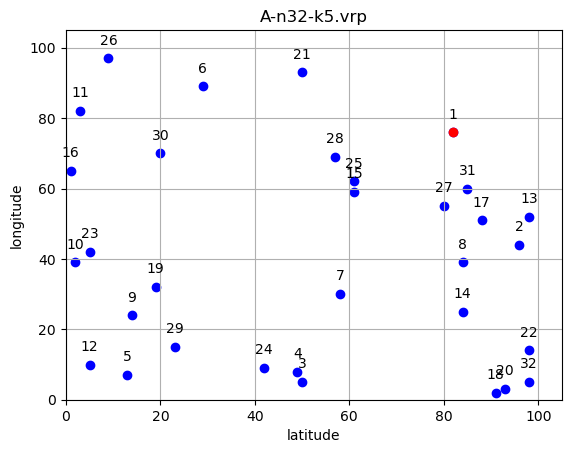

Soluzione ottima: 784
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 784
Route for vehicle 1:
 1 Load(0) ->  31 Load(14) ->  17 Load(32) ->  2 Load(51) ->  13 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of the route: 72

Route for vehicle 2:
 1 Load(0) ->  30 Load(2) ->  19 Load(3) ->  9 Load(9) ->  10 Load(25) ->  23 Load(29) ->  16 Load(51) ->  11 Load(59) ->  26 Load(83) ->  6 Load(90) ->  21 Load(98) ->  0 Load(98)
Distance of the route: 267m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  22 Load(12) ->  32 Load(21) ->  20 Load(45) ->  18 Load(64) ->  14 Load(80) ->  8 Load(96) ->  27 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  7 Load(12) ->  4 Load(18) ->  3 Load(39) ->  24 Load(47) ->  5 Load(66) ->  12 Load(80) ->  29 Load(95) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 230m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  25 Load(24)

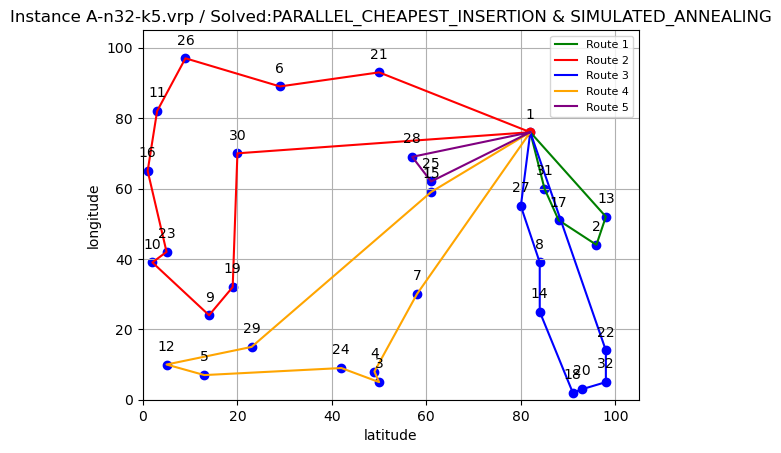

Local Search: TABU_SEARCH
Objective: 846
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  17 Load(58) ->  31 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of the route: 72

Route for vehicle 2:
 1 Load(0) ->  28 Load(20) ->  30 Load(22) ->  16 Load(44) ->  11 Load(52) ->  26 Load(76) ->  6 Load(83) ->  21 Load(91) ->  0 Load(91)
Distance of the route: 195m
Load of the route: 91

Route for vehicle 3:
 1 Load(0) ->  29 Load(15) ->  12 Load(29) ->  5 Load(48) ->  24 Load(56) ->  3 Load(77) ->  4 Load(83) ->  7 Load(95) ->  0 Load(95)
Distance of the route: 230m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  25 Load(24) ->  23 Load(28) ->  10 Load(44) ->  9 Load(50) ->  19 Load(51) ->  15 Load(54) ->  0 Load(54)
Distance of the route: 193m
Load of the route: 54

Route for vehicle 5:
 1 Load(0) ->  27 Load(2) ->  8 Load(18) ->  14 Load(34) ->  18 Load(53) ->  20 Load(77) ->  32 Load(86) ->  22 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load o

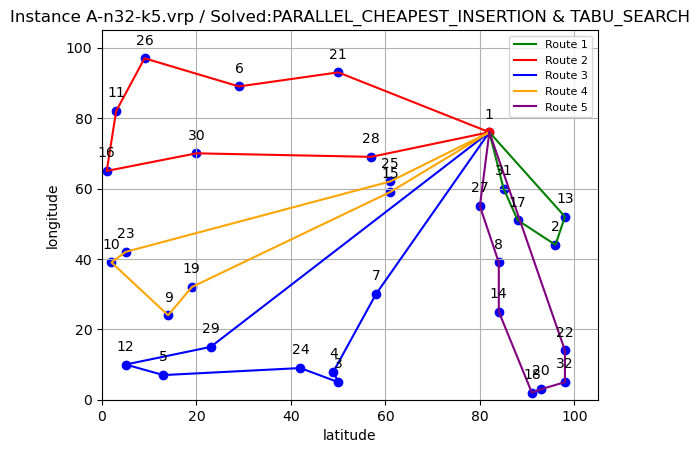

Local Search: GUIDED_LOCAL_SEARCH
Objective: 846
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  17 Load(58) ->  31 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of the route: 72

Route for vehicle 2:
 1 Load(0) ->  28 Load(20) ->  30 Load(22) ->  16 Load(44) ->  11 Load(52) ->  26 Load(76) ->  6 Load(83) ->  21 Load(91) ->  0 Load(91)
Distance of the route: 195m
Load of the route: 91

Route for vehicle 3:
 1 Load(0) ->  29 Load(15) ->  12 Load(29) ->  5 Load(48) ->  24 Load(56) ->  4 Load(62) ->  3 Load(83) ->  7 Load(95) ->  0 Load(95)
Distance of the route: 230m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  25 Load(24) ->  23 Load(28) ->  10 Load(44) ->  9 Load(50) ->  19 Load(51) ->  15 Load(54) ->  0 Load(54)
Distance of the route: 193m
Load of the route: 54

Route for vehicle 5:
 1 Load(0) ->  27 Load(2) ->  8 Load(18) ->  14 Load(34) ->  18 Load(53) ->  20 Load(77) ->  32 Load(86) ->  22 Load(98) ->  0 Load(98)
Distance of the route: 155

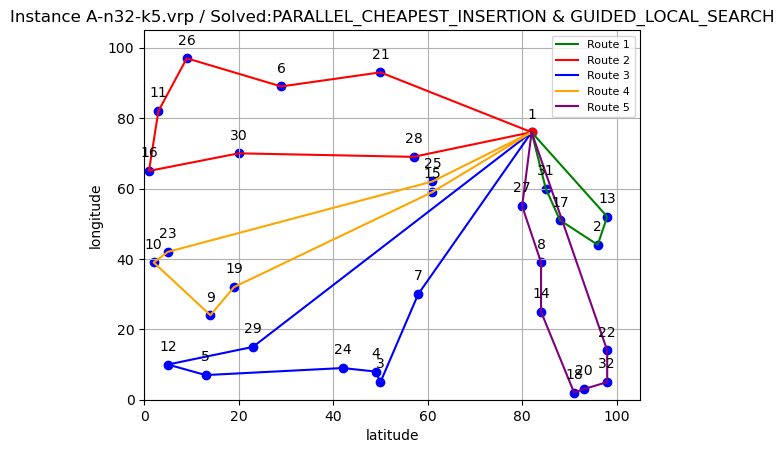

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 837
Route for vehicle 1:
 1 Load(0) ->  7 Load(12) ->  24 Load(20) ->  4 Load(26) ->  3 Load(47) ->  2 Load(66) ->  13 Load(87) ->  0 Load(87)
Distance of the route: 185m
Load of the route: 87

Route for vehicle 2:
 1 Load(0) ->  25 Load(24) ->  28 Load(44) ->  30 Load(46) ->  11 Load(54) ->  26 Load(78) ->  6 Load(85) ->  21 Load(93) ->  0 Load(93)
Distance of the route: 186m
Load of the route: 93

Route for vehicle 3:
 1 Load(0) ->  27 Load(2) ->  8 Load(18) ->  14 Load(34) ->  18 Load(53) ->  20 Load(77) ->  32 Load(86) ->  22 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  17 Load(18) ->  31 Load(32) ->  0 Load(32)
Distance of the route: 51m
Load of the route: 32

Route for vehicle 5:
 1 Load(0) ->  15 Load(3) ->  29 Load(18) ->  5 Load(37) ->  12 Load(51) ->  9 Load(57) ->  19 Load(58) ->  10 Load(74) ->  23 Load(78) ->  16 Load(100) ->  0 Load(100)
Distanc

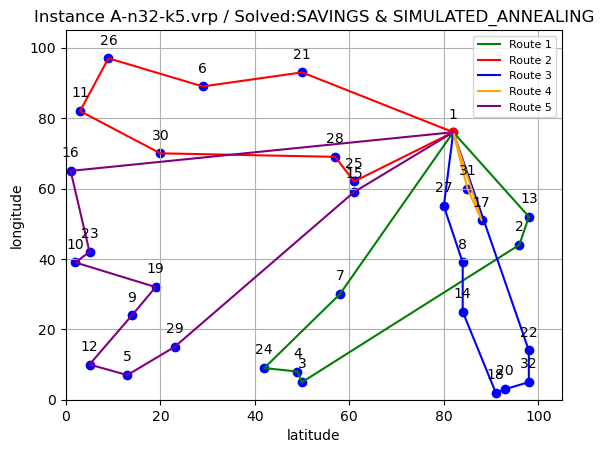

Local Search: TABU_SEARCH
Objective: 796
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  2 Load(40) ->  8 Load(56) ->  17 Load(74) ->  31 Load(88) ->  0 Load(88)
Distance of the route: 88m
Load of the route: 88

Route for vehicle 2:
 1 Load(0) ->  30 Load(2) ->  23 Load(6) ->  10 Load(22) ->  16 Load(44) ->  11 Load(52) ->  26 Load(76) ->  6 Load(83) ->  21 Load(91) ->  0 Load(91)
Distance of the route: 236m
Load of the route: 91

Route for vehicle 3:
 1 Load(0) ->  27 Load(2) ->  14 Load(18) ->  22 Load(30) ->  32 Load(39) ->  20 Load(63) ->  18 Load(82) ->  7 Load(94) ->  0 Load(94)
Distance of the route: 180m
Load of the route: 94

Route for vehicle 4:
 1 Load(0) ->  15 Load(3) ->  19 Load(4) ->  9 Load(10) ->  12 Load(24) ->  5 Load(43) ->  29 Load(58) ->  24 Load(66) ->  3 Load(87) ->  4 Load(93) ->  0 Load(93)
Distance of the route: 233m
Load of the route: 93

Route for vehicle 5:
 1 Load(0) ->  28 Load(20) ->  25 Load(44) ->  0 Load(44)
Distance of the route: 59m
Load of the

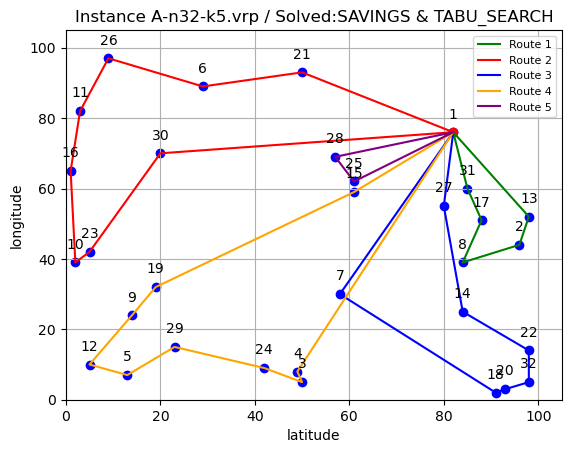

Local Search: GUIDED_LOCAL_SEARCH
Objective: 820
Route for vehicle 1:
 1 Load(0) ->  31 Load(14) ->  17 Load(32) ->  2 Load(51) ->  13 Load(72) ->  0 Load(72)
Distance of the route: 73m
Load of the route: 72

Route for vehicle 2:
 1 Load(0) ->  7 Load(12) ->  4 Load(18) ->  24 Load(26) ->  19 Load(27) ->  16 Load(49) ->  11 Load(57) ->  26 Load(81) ->  6 Load(88) ->  21 Load(96) ->  0 Load(96)
Distance of the route: 266m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  22 Load(12) ->  32 Load(21) ->  20 Load(45) ->  18 Load(64) ->  14 Load(80) ->  8 Load(96) ->  27 Load(98) ->  0 Load(98)
Distance of the route: 155m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  15 Load(3) ->  3 Load(24) ->  29 Load(39) ->  5 Load(58) ->  12 Load(72) ->  9 Load(78) ->  10 Load(94) ->  23 Load(98) ->  30 Load(100) ->  0 Load(100)
Distance of the route: 267m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  28 Load(20) ->  25 Load(44) ->  0 Load(44)
Distance of the route: 

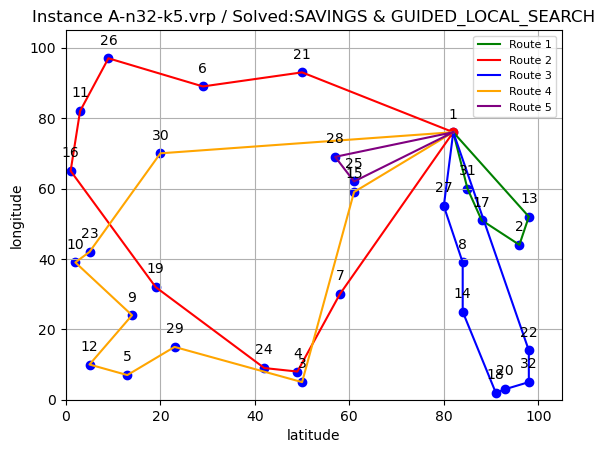

Soluzione ottima: 784
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 784
Gap: 0.0%
Tempo di esecuzione: 2.0120105743408203s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 846
Gap: 7.908163265306123%
Tempo di esecuzione: 1.9999990463256836s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 846
Gap: 7.908163265306123%
Tempo di esecuzione: 2.000974655151367s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 837
Gap: 6.760204081632653%
Tempo di esecuzione: 2.0000159740448s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 796
Gap: 1.530612244897959%
Tempo di esecuzione: 2.001028299331665s
----

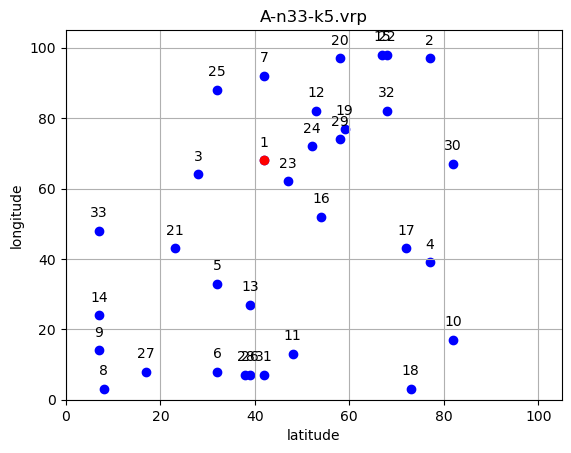

Soluzione ottima: 661
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 717
Route for vehicle 1:
 1 Load(0) ->  12 Load(5) ->  32 Load(29) ->  19 Load(42) ->  29 Load(57) ->  24 Load(71) ->  0 Load(71)
Distance of the route: 63m
Load of the route: 71

Route for vehicle 2:
 1 Load(0) ->  3 Load(23) ->  25 Load(36) ->  7 Load(54) ->  20 Load(68) ->  15 Load(77) ->  22 Load(87) ->  2 Load(92) ->  30 Load(100) ->  0 Load(100)
Distance of the route: 156m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  23 Load(19) ->  17 Load(29) ->  31 Load(49) ->  26 Load(63) ->  28 Load(86) ->  13 Load(95) ->  0 Load(95)
Distance of the route: 151m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  21 Load(8) ->  33 Load(11) ->  14 Load(34) ->  9 Load(44) ->  8 Load(63) ->  27 Load(65) ->  6 Load(73) ->  5 Load(86) ->  0 Load(86)
Distance of the route: 179m
Load of the route: 86

Route for vehicle 5:
 1 Load(0) ->  11 Load(20) ->  18 Load(44) ->  10 Loa

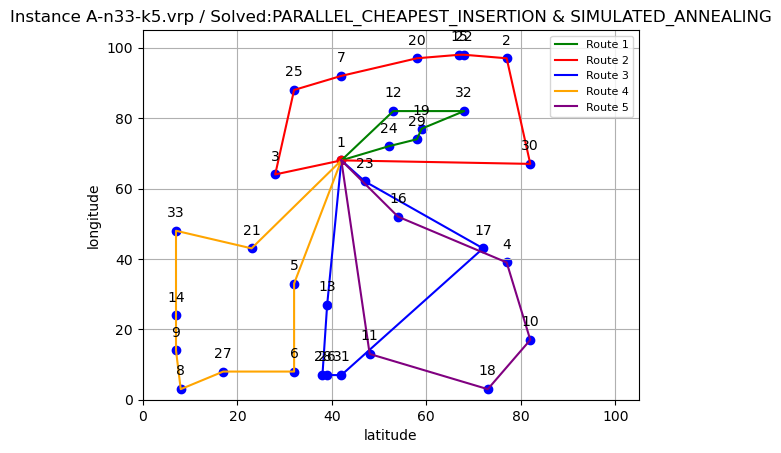

Local Search: TABU_SEARCH
Objective: 696
Route for vehicle 1:
 1 Load(0) ->  25 Load(13) ->  7 Load(31) ->  12 Load(36) ->  19 Load(49) ->  29 Load(64) ->  24 Load(78) ->  0 Load(78)
Distance of the route: 76m
Load of the route: 78

Route for vehicle 2:
 1 Load(0) ->  20 Load(14) ->  15 Load(23) ->  22 Load(33) ->  2 Load(38) ->  32 Load(62) ->  30 Load(70) ->  4 Load(84) ->  17 Load(94) ->  0 Load(94)
Distance of the route: 163m
Load of the route: 94

Route for vehicle 3:
 1 Load(0) ->  23 Load(19) ->  16 Load(37) ->  5 Load(50) ->  21 Load(58) ->  3 Load(81) ->  0 Load(81)
Distance of the route: 99m
Load of the route: 81

Route for vehicle 4:
 1 Load(0) ->  33 Load(3) ->  14 Load(26) ->  9 Load(36) ->  8 Load(55) ->  27 Load(57) ->  6 Load(65) ->  28 Load(88) ->  13 Load(97) ->  0 Load(97)
Distance of the route: 177m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  26 Load(14) ->  31 Load(34) ->  11 Load(54) ->  18 Load(78) ->  10 Load(96) ->  0 Load(96)
Distance of the rou

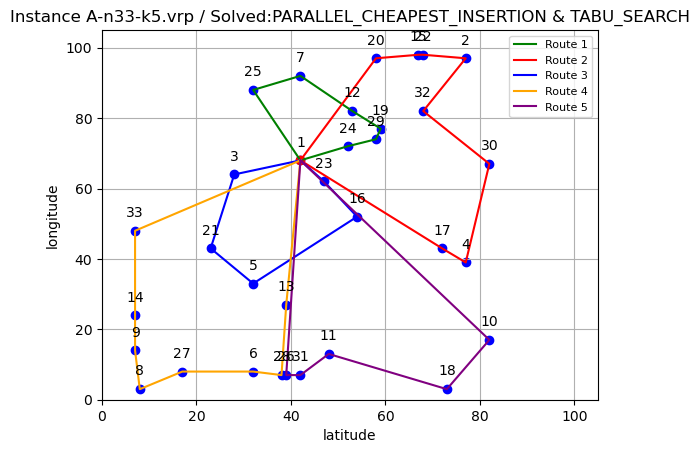

Local Search: GUIDED_LOCAL_SEARCH
Objective: 683
Route for vehicle 1:
 1 Load(0) ->  12 Load(5) ->  32 Load(29) ->  19 Load(42) ->  29 Load(57) ->  24 Load(71) ->  0 Load(71)
Distance of the route: 63m
Load of the route: 71

Route for vehicle 2:
 1 Load(0) ->  25 Load(13) ->  7 Load(31) ->  20 Load(45) ->  15 Load(54) ->  22 Load(64) ->  2 Load(69) ->  30 Load(77) ->  23 Load(96) ->  0 Load(96)
Distance of the route: 142m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  11 Load(20) ->  31 Load(40) ->  26 Load(54) ->  5 Load(67) ->  21 Load(75) ->  3 Load(98) ->  0 Load(98)
Distance of the route: 143m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  33 Load(3) ->  14 Load(26) ->  9 Load(36) ->  8 Load(55) ->  27 Load(57) ->  6 Load(65) ->  28 Load(88) ->  13 Load(97) ->  0 Load(97)
Distance of the route: 177m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  16 Load(18) ->  18 Load(42) ->  10 Load(60) ->  4 Load(74) ->  17 Load(84) ->  0 Load(84)
Distance of

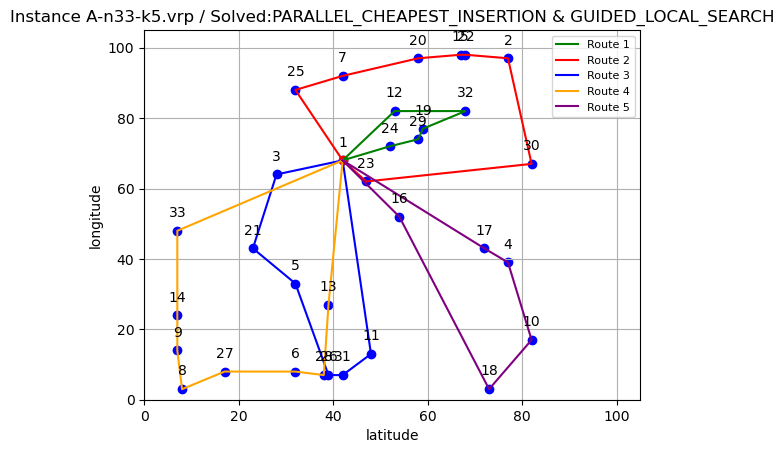

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 705
Route for vehicle 1:
 1 Load(0) ->  12 Load(5) ->  32 Load(29) ->  19 Load(42) ->  29 Load(57) ->  24 Load(71) ->  0 Load(71)
Distance of the route: 63m
Load of the route: 71

Route for vehicle 2:
 1 Load(0) ->  3 Load(23) ->  25 Load(36) ->  7 Load(54) ->  20 Load(68) ->  15 Load(77) ->  22 Load(87) ->  2 Load(92) ->  30 Load(100) ->  0 Load(100)
Distance of the route: 156m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  23 Load(19) ->  16 Load(37) ->  11 Load(57) ->  13 Load(66) ->  5 Load(79) ->  21 Load(87) ->  0 Load(87)
Distance of the route: 129m
Load of the route: 87

Route for vehicle 4:
 1 Load(0) ->  33 Load(3) ->  14 Load(26) ->  9 Load(36) ->  8 Load(55) ->  27 Load(57) ->  6 Load(65) ->  28 Load(88) ->  0 Load(88)
Distance of the route: 177m
Load of the route: 88

Route for vehicle 5:
 1 Load(0) ->  26 Load(14) ->  31 Load(34) ->  18 Load(58) ->  10 Load(76) ->  4 Load(90) ->  17 Load(100) ->  

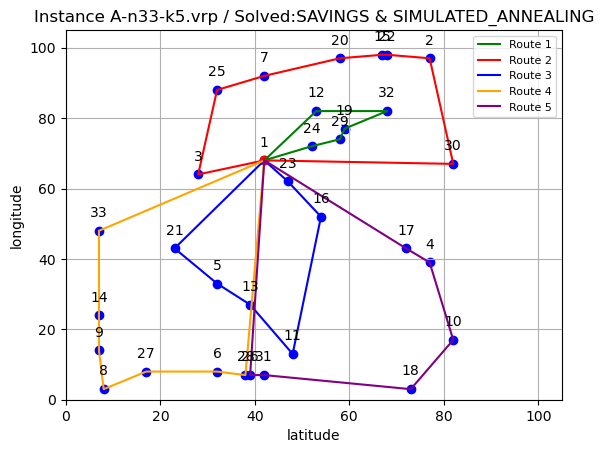

Local Search: TABU_SEARCH
Objective: 714
Route for vehicle 1:
 1 Load(0) ->  11 Load(20) ->  18 Load(44) ->  10 Load(62) ->  16 Load(80) ->  23 Load(99) ->  0 Load(99)
Distance of the route: 164m
Load of the route: 99

Route for vehicle 2:
 1 Load(0) ->  3 Load(23) ->  25 Load(36) ->  7 Load(54) ->  20 Load(68) ->  15 Load(77) ->  22 Load(87) ->  2 Load(92) ->  30 Load(100) ->  0 Load(100)
Distance of the route: 156m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  21 Load(8) ->  33 Load(11) ->  14 Load(34) ->  9 Load(44) ->  8 Load(63) ->  27 Load(65) ->  5 Load(78) ->  0 Load(78)
Distance of the route: 168m
Load of the route: 78

Route for vehicle 4:
 1 Load(0) ->  17 Load(10) ->  4 Load(24) ->  31 Load(44) ->  26 Load(58) ->  28 Load(81) ->  6 Load(89) ->  13 Load(98) ->  0 Load(98)
Distance of the route: 163m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  24 Load(14) ->  29 Load(29) ->  19 Load(42) ->  32 Load(66) ->  12 Load(71) ->  0 Load(71)
Distance of th

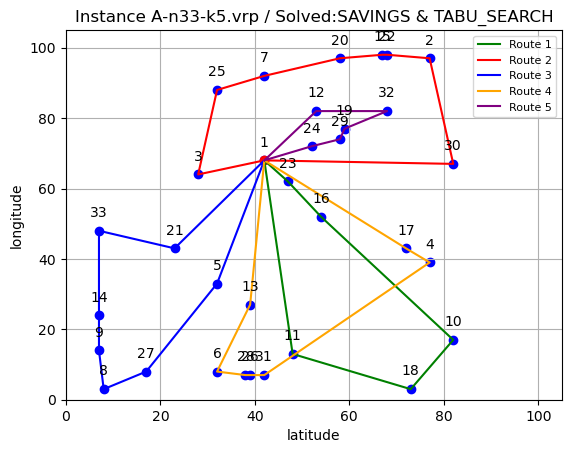

Local Search: GUIDED_LOCAL_SEARCH
Objective: 690
Route for vehicle 1:
 1 Load(0) ->  12 Load(5) ->  32 Load(29) ->  19 Load(42) ->  29 Load(57) ->  24 Load(71) ->  0 Load(71)
Distance of the route: 63m
Load of the route: 71

Route for vehicle 2:
 1 Load(0) ->  3 Load(23) ->  25 Load(36) ->  7 Load(54) ->  20 Load(68) ->  15 Load(77) ->  22 Load(87) ->  2 Load(92) ->  30 Load(100) ->  0 Load(100)
Distance of the route: 156m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  21 Load(8) ->  33 Load(11) ->  14 Load(34) ->  9 Load(44) ->  8 Load(63) ->  27 Load(65) ->  6 Load(73) ->  13 Load(82) ->  5 Load(95) ->  0 Load(95)
Distance of the route: 183m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  23 Load(19) ->  11 Load(39) ->  31 Load(59) ->  26 Load(73) ->  28 Load(96) ->  0 Load(96)
Distance of the route: 130m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  16 Load(18) ->  18 Load(42) ->  10 Load(60) ->  4 Load(74) ->  17 Load(84) ->  0 Load(84)
Distance

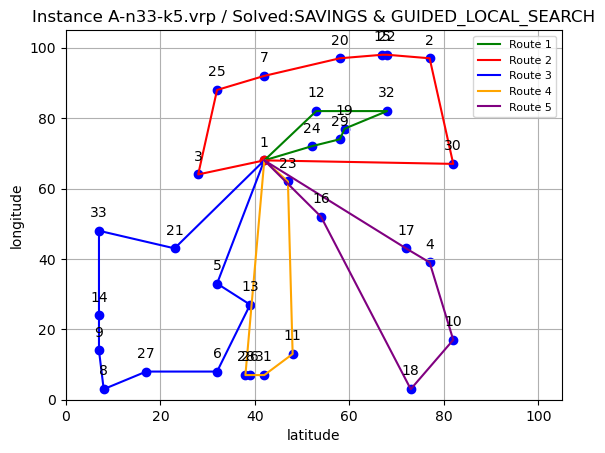

Soluzione ottima: 661
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 717
Gap: 8.472012102874432%
Tempo di esecuzione: 2.0010008811950684s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 696
Gap: 5.29500756429652%
Tempo di esecuzione: 2.0010006427764893s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 683
Gap: 3.3282904689863844%
Tempo di esecuzione: 2.0009984970092773s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 705
Gap: 6.656580937972769%
Tempo di esecuzione: 1.9999971389770508s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 714
Gap: 8.018154311649017%
Tempo di esecuzione: 2.000

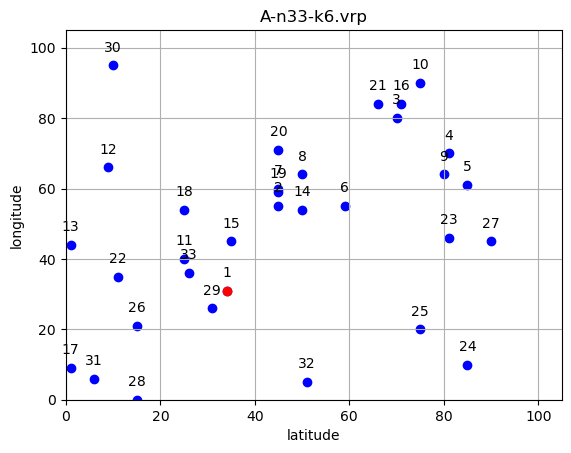

Soluzione ottima: 742
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 783
Route for vehicle 1:
 1 Load(0) ->  18 Load(17) ->  20 Load(39) ->  8 Load(54) ->  7 Load(59) ->  19 Load(76) ->  15 Load(92) ->  0 Load(92)
Distance of the route: 98m
Load of the route: 92

Route for vehicle 2:
 1 Load(0) ->  33 Load(22) ->  26 Load(33) ->  17 Load(40) ->  31 Load(65) ->  28 Load(76) ->  29 Load(97) ->  0 Load(97)
Distance of the route: 100m
Load of the route: 97

Route for vehicle 3:
 1 Load(0) ->  32 Load(2) ->  24 Load(9) ->  25 Load(30) ->  14 Load(55) ->  2 Load(81) ->  0 Load(81)
Distance of the route: 152m
Load of the route: 81

Route for vehicle 4:
 1 Load(0) ->  13 Load(66) ->  22 Load(91) ->  0 Load(91)
Distance of the route: 71m
Load of the route: 91

Route for vehicle 5:
 1 Load(0) ->  6 Load(7) ->  9 Load(23) ->  4 Load(29) ->  5 Load(44) ->  27 Load(65) ->  23 Load(81) ->  0 Load(81)
Distance of the route: 149m
Load of the route: 81

Route for veh

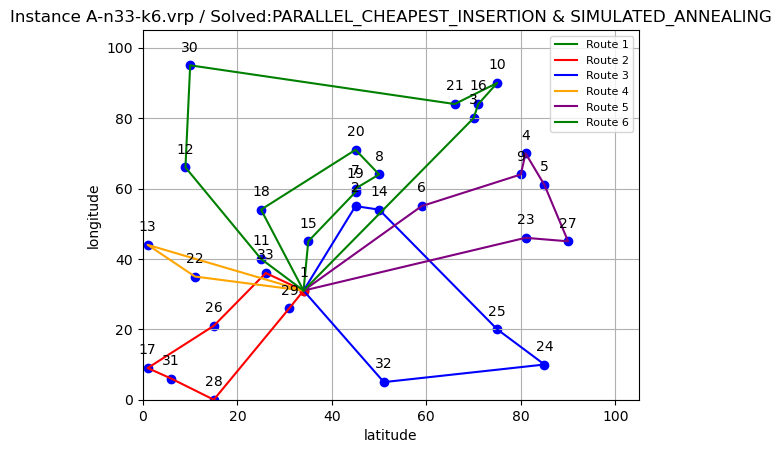

Local Search: TABU_SEARCH
Objective: 798
Route for vehicle 1:
 1 Load(0) ->  2 Load(26) ->  19 Load(43) ->  18 Load(60) ->  11 Load(61) ->  33 Load(83) ->  0 Load(83)
Distance of the route: 78m
Load of the route: 83

Route for vehicle 2:
 1 Load(0) ->  13 Load(66) ->  22 Load(91) ->  0 Load(91)
Distance of the route: 71m
Load of the route: 91

Route for vehicle 3:
 1 Load(0) ->  20 Load(22) ->  21 Load(32) ->  16 Load(43) ->  3 Load(60) ->  8 Load(75) ->  7 Load(80) ->  15 Load(96) ->  0 Load(96)
Distance of the route: 139m
Load of the route: 96

Route for vehicle 4:
 1 Load(0) ->  14 Load(25) ->  6 Load(32) ->  4 Load(38) ->  10 Load(55) ->  30 Load(77) ->  12 Load(98) ->  0 Load(98)
Distance of the route: 222m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  32 Load(2) ->  24 Load(9) ->  25 Load(30) ->  23 Load(46) ->  27 Load(67) ->  5 Load(82) ->  9 Load(98) ->  0 Load(98)
Distance of the route: 195m
Load of the route: 98

Route for vehicle 6:
 1 Load(0) ->  29 Load(21) -

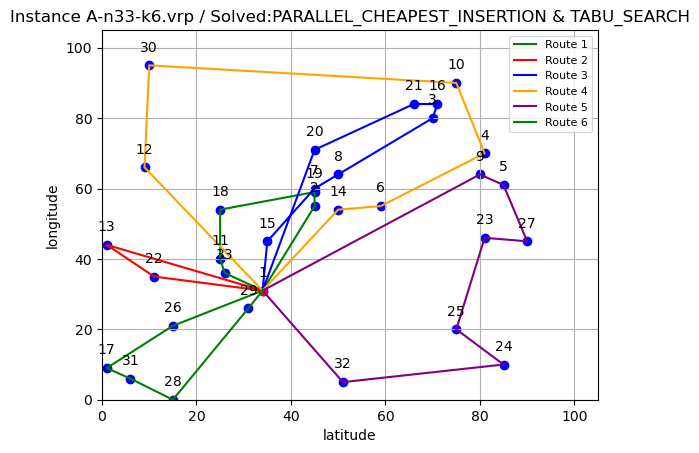

Local Search: GUIDED_LOCAL_SEARCH
Objective: 743
Route for vehicle 1:
 1 Load(0) ->  15 Load(16) ->  18 Load(33) ->  30 Load(55) ->  12 Load(76) ->  11 Load(77) ->  33 Load(99) ->  0 Load(99)
Distance of the route: 144m
Load of the route: 99

Route for vehicle 2:
 1 Load(0) ->  13 Load(66) ->  22 Load(91) ->  0 Load(91)
Distance of the route: 71m
Load of the route: 91

Route for vehicle 3:
 1 Load(0) ->  14 Load(25) ->  8 Load(40) ->  7 Load(45) ->  19 Load(62) ->  2 Load(88) ->  0 Load(88)
Distance of the route: 75m
Load of the route: 88

Route for vehicle 4:
 1 Load(0) ->  29 Load(21) ->  28 Load(32) ->  31 Load(57) ->  17 Load(64) ->  26 Load(75) ->  0 Load(75)
Distance of the route: 93m
Load of the route: 75

Route for vehicle 5:
 1 Load(0) ->  32 Load(2) ->  24 Load(9) ->  25 Load(30) ->  23 Load(46) ->  27 Load(67) ->  5 Load(82) ->  9 Load(98) ->  0 Load(98)
Distance of the route: 195m
Load of the route: 98

Route for vehicle 6:
 1 Load(0) ->  6 Load(7) ->  4 Load(13) ->  3 Load

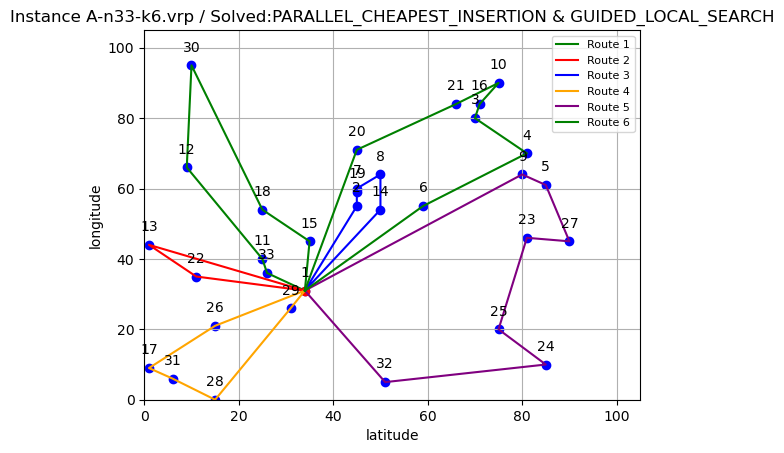

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 770
Route for vehicle 1:
 1 Load(0) ->  15 Load(16) ->  19 Load(33) ->  7 Load(38) ->  8 Load(53) ->  18 Load(70) ->  11 Load(71) ->  33 Load(93) ->  0 Load(93)
Distance of the route: 92m
Load of the route: 93

Route for vehicle 2:
 1 Load(0) ->  29 Load(21) ->  28 Load(32) ->  31 Load(57) ->  17 Load(64) ->  26 Load(75) ->  0 Load(75)
Distance of the route: 93m
Load of the route: 75

Route for vehicle 3:
 1 Load(0) ->  6 Load(7) ->  4 Load(13) ->  10 Load(30) ->  16 Load(41) ->  21 Load(51) ->  3 Load(68) ->  14 Load(93) ->  0 Load(93)
Distance of the route: 162m
Load of the route: 93

Route for vehicle 4:
 1 Load(0) ->  13 Load(66) ->  22 Load(91) ->  0 Load(91)
Distance of the route: 71m
Load of the route: 91

Route for vehicle 5:
 1 Load(0) ->  32 Load(2) ->  25 Load(23) ->  24 Load(30) ->  27 Load(51) ->  23 Load(67) ->  5 Load(82) ->  9 Load(98) ->  0 Load(98)
Distance of the route: 196m
Load of the route: 98

Route f

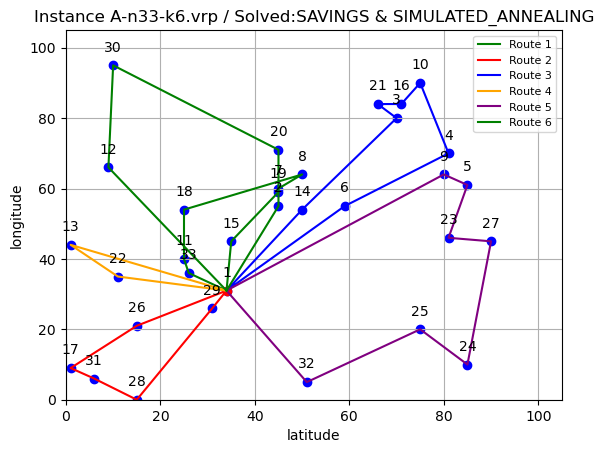

Local Search: TABU_SEARCH
Objective: 789
Route for vehicle 1:
 1 Load(0) ->  26 Load(11) ->  17 Load(18) ->  31 Load(43) ->  28 Load(54) ->  29 Load(75) ->  0 Load(75)
Distance of the route: 93m
Load of the route: 75

Route for vehicle 2:
 1 Load(0) ->  15 Load(16) ->  18 Load(33) ->  30 Load(55) ->  12 Load(76) ->  11 Load(77) ->  33 Load(99) ->  0 Load(99)
Distance of the route: 144m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  2 Load(26) ->  8 Load(41) ->  20 Load(63) ->  7 Load(68) ->  19 Load(85) ->  0 Load(85)
Distance of the route: 87m
Load of the route: 85

Route for vehicle 4:
 1 Load(0) ->  32 Load(2) ->  24 Load(9) ->  3 Load(26) ->  16 Load(37) ->  10 Load(54) ->  21 Load(64) ->  6 Load(71) ->  14 Load(96) ->  0 Load(96)
Distance of the route: 226m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  25 Load(21) ->  23 Load(37) ->  27 Load(58) ->  5 Load(73) ->  4 Load(79) ->  9 Load(95) ->  0 Load(95)
Distance of the route: 168m
Load of the route: 95

R

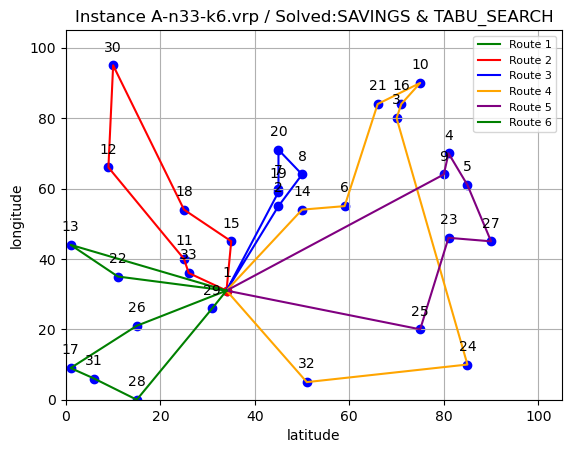

Local Search: GUIDED_LOCAL_SEARCH
Objective: 877
Route for vehicle 1:
 1 Load(0) ->  15 Load(16) ->  18 Load(33) ->  11 Load(34) ->  33 Load(56) ->  29 Load(77) ->  0 Load(77)
Distance of the route: 62m
Load of the route: 77

Route for vehicle 2:
 1 Load(0) ->  24 Load(7) ->  32 Load(9) ->  28 Load(20) ->  31 Load(45) ->  17 Load(52) ->  26 Load(63) ->  22 Load(88) ->  0 Load(88)
Distance of the route: 198m
Load of the route: 88

Route for vehicle 3:
 1 Load(0) ->  19 Load(17) ->  7 Load(22) ->  20 Load(44) ->  8 Load(59) ->  6 Load(66) ->  14 Load(91) ->  0 Load(91)
Distance of the route: 101m
Load of the route: 91

Route for vehicle 4:
 1 Load(0) ->  13 Load(66) ->  12 Load(87) ->  0 Load(87)
Distance of the route: 101m
Load of the route: 87

Route for vehicle 5:
 1 Load(0) ->  25 Load(21) ->  23 Load(37) ->  27 Load(58) ->  5 Load(73) ->  9 Load(89) ->  16 Load(100) ->  0 Load(100)
Distance of the route: 188m
Load of the route: 100

Route for vehicle 6:
 1 Load(0) ->  2 Load(26) -> 

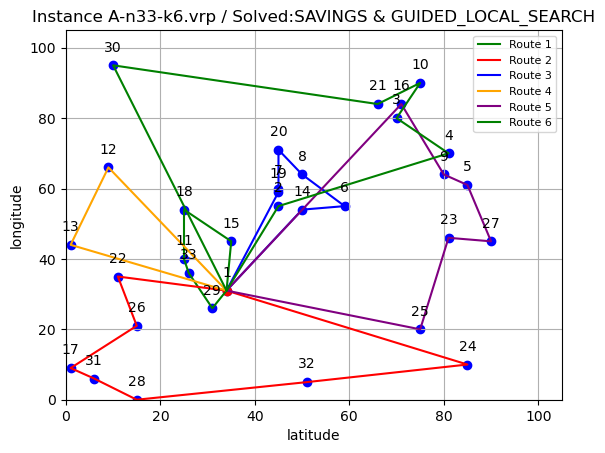

Soluzione ottima: 742
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 783
Gap: 5.525606469002695%
Tempo di esecuzione: 2.000999927520752s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 798
Gap: 7.547169811320755%
Tempo di esecuzione: 2.0010039806365967s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 743
Gap: 0.13477088948787064%
Tempo di esecuzione: 1.9999668598175049s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 770
Gap: 3.7735849056603774%
Tempo di esecuzione: 2.0000033378601074s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 789
Gap: 6.334231805929918%
Tempo di esecuzione: 2.0

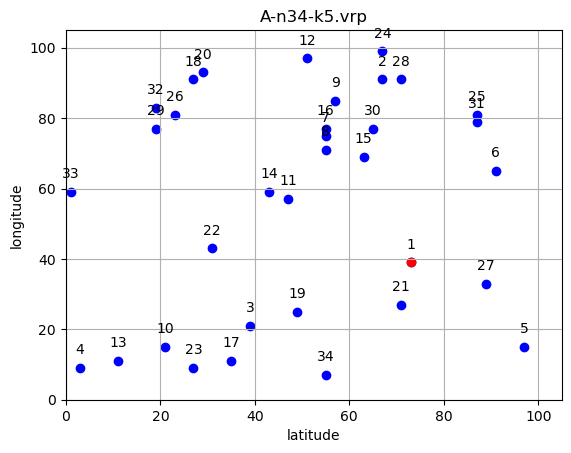

Soluzione ottima: 778
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 786
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  17 Load(60) ->  21 Load(73) ->  0 Load(73)
Distance of the route: 151m
Load of the route: 73

Route for vehicle 2:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  30 Load(66) ->  7 Load(90) ->  8 Load(97) ->  0 Load(97)
Distance of the route: 122m
Load of the route: 97

Route for vehicle 3:
 1 Load(0) ->  28 Load(3) ->  2 Load(26) ->  24 Load(50) ->  12 Load(57) ->  9 Load(82) ->  16 Load(87) ->  15 Load(100) ->  0 Load(100)
Distance of the route: 144m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  22 Load(16) ->  33 Load(31) ->  4 Load(55) ->  13 Load(60) ->  10 Load(73) ->  23 Load(86) ->  3 Load(89) ->  19 Load(98) ->  0 Load(98)
Distance of the route: 209m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  11 Load(5) ->  14 Load(19) ->  29 Load(34) ->  32 Loa

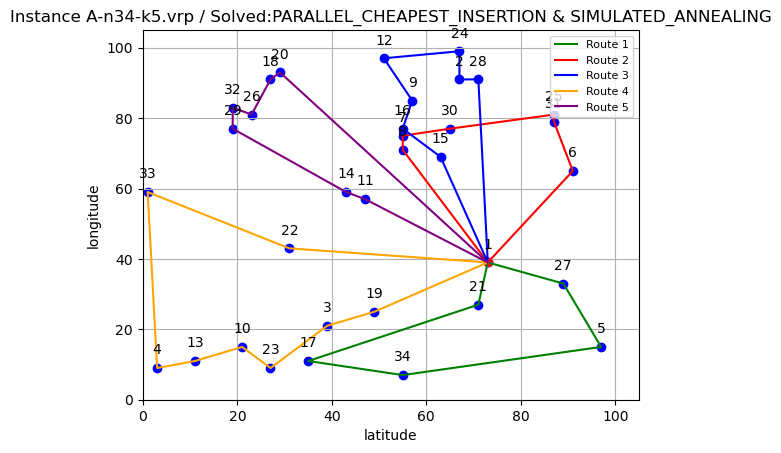

Local Search: TABU_SEARCH
Objective: 790
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  17 Load(60) ->  21 Load(73) ->  0 Load(73)
Distance of the route: 151m
Load of the route: 73

Route for vehicle 2:
 1 Load(0) ->  12 Load(7) ->  20 Load(23) ->  18 Load(38) ->  26 Load(61) ->  32 Load(65) ->  29 Load(80) ->  14 Load(94) ->  11 Load(99) ->  0 Load(99)
Distance of the route: 174m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  8 Load(7) ->  16 Load(12) ->  9 Load(37) ->  24 Load(61) ->  28 Load(64) ->  2 Load(87) ->  15 Load(100) ->  0 Load(100)
Distance of the route: 135m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  22 Load(16) ->  33 Load(31) ->  4 Load(55) ->  13 Load(60) ->  10 Load(73) ->  23 Load(86) ->  3 Load(89) ->  19 Load(98) ->  0 Load(98)
Distance of the route: 209m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  30 Load(66) ->  7 Load(90) ->  0 Load(90)

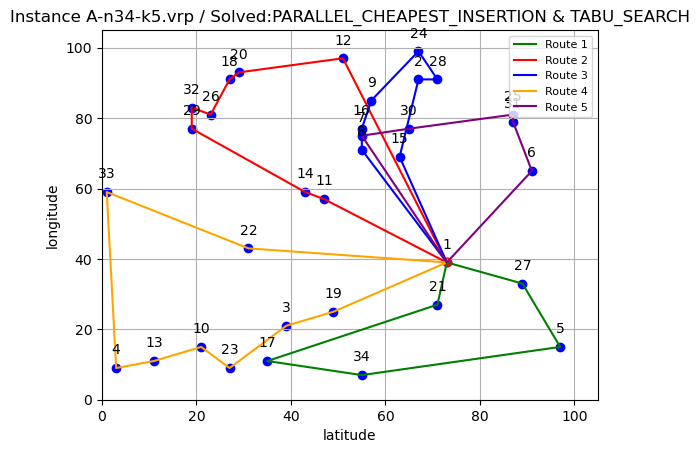

Local Search: GUIDED_LOCAL_SEARCH
Objective: 832
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  17 Load(60) ->  23 Load(73) ->  19 Load(82) ->  21 Load(95) ->  0 Load(95)
Distance of the route: 169m
Load of the route: 95

Route for vehicle 2:
 1 Load(0) ->  28 Load(3) ->  24 Load(27) ->  20 Load(43) ->  18 Load(58) ->  26 Load(81) ->  14 Load(95) ->  11 Load(100) ->  0 Load(100)
Distance of the route: 179m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  8 Load(7) ->  7 Load(31) ->  16 Load(36) ->  9 Load(61) ->  12 Load(68) ->  2 Load(91) ->  0 Load(91)
Distance of the route: 133m
Load of the route: 91

Route for vehicle 4:
 1 Load(0) ->  22 Load(16) ->  29 Load(31) ->  32 Load(35) ->  33 Load(50) ->  4 Load(74) ->  13 Load(79) ->  10 Load(92) ->  3 Load(95) ->  0 Load(95)
Distance of the route: 240m
Load of the route: 95

Route for vehicle 5:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  30 Load(66) ->  15 Load(79) ->  0 

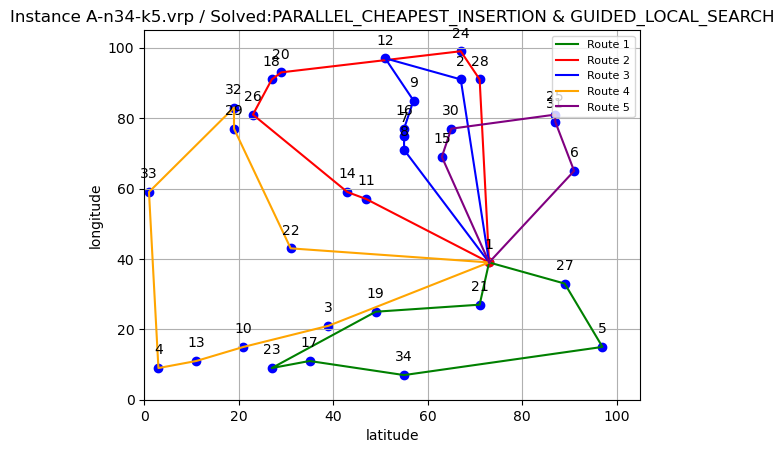

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 786
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  17 Load(60) ->  21 Load(73) ->  0 Load(73)
Distance of the route: 151m
Load of the route: 73

Route for vehicle 2:
 1 Load(0) ->  8 Load(7) ->  20 Load(23) ->  18 Load(38) ->  32 Load(42) ->  26 Load(65) ->  29 Load(80) ->  14 Load(94) ->  11 Load(99) ->  0 Load(99)
Distance of the route: 161m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  30 Load(66) ->  16 Load(71) ->  7 Load(95) ->  0 Load(95)
Distance of the route: 123m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  22 Load(16) ->  33 Load(31) ->  4 Load(55) ->  13 Load(60) ->  10 Load(73) ->  23 Load(86) ->  3 Load(89) ->  19 Load(98) ->  0 Load(98)
Distance of the route: 209m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  28 Load(3) ->  2 Load(26) ->  24 Load(50) ->  12 Load(57) ->  9 Load(82) ->  15 

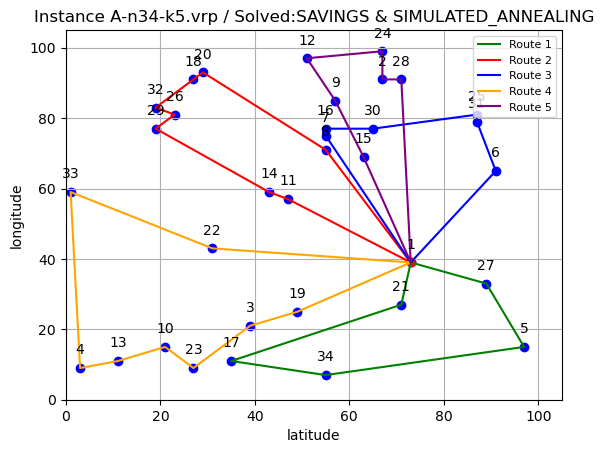

Local Search: TABU_SEARCH
Objective: 786
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  17 Load(60) ->  21 Load(73) ->  0 Load(73)
Distance of the route: 151m
Load of the route: 73

Route for vehicle 2:
 1 Load(0) ->  8 Load(7) ->  20 Load(23) ->  18 Load(38) ->  32 Load(42) ->  26 Load(65) ->  29 Load(80) ->  14 Load(94) ->  11 Load(99) ->  0 Load(99)
Distance of the route: 161m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  30 Load(66) ->  16 Load(71) ->  7 Load(95) ->  0 Load(95)
Distance of the route: 123m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  22 Load(16) ->  33 Load(31) ->  4 Load(55) ->  13 Load(60) ->  10 Load(73) ->  23 Load(86) ->  3 Load(89) ->  19 Load(98) ->  0 Load(98)
Distance of the route: 209m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  28 Load(3) ->  2 Load(26) ->  24 Load(50) ->  12 Load(57) ->  9 Load(82) ->  15 Load(95) ->  0 Load(95)
Di

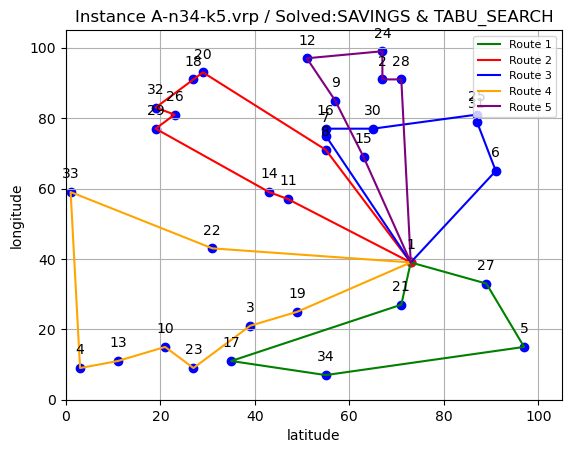

Local Search: GUIDED_LOCAL_SEARCH
Objective: 845
Route for vehicle 1:
 1 Load(0) ->  27 Load(20) ->  5 Load(35) ->  34 Load(36) ->  23 Load(49) ->  17 Load(73) ->  21 Load(86) ->  0 Load(86)
Distance of the route: 167m
Load of the route: 86

Route for vehicle 2:
 1 Load(0) ->  6 Load(15) ->  31 Load(34) ->  25 Load(54) ->  15 Load(67) ->  8 Load(74) ->  11 Load(79) ->  0 Load(79)
Distance of the route: 132m
Load of the route: 79

Route for vehicle 3:
 1 Load(0) ->  30 Load(12) ->  2 Load(35) ->  12 Load(42) ->  9 Load(67) ->  16 Load(72) ->  7 Load(96) ->  0 Load(96)
Distance of the route: 133m
Load of the route: 96

Route for vehicle 4:
 1 Load(0) ->  22 Load(16) ->  29 Load(31) ->  33 Load(46) ->  4 Load(70) ->  13 Load(75) ->  10 Load(88) ->  3 Load(91) ->  19 Load(100) ->  0 Load(100)
Distance of the route: 230m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  28 Load(3) ->  24 Load(27) ->  20 Load(43) ->  18 Load(58) ->  32 Load(62) ->  26 Load(85) ->  14 Load(99) ->  0

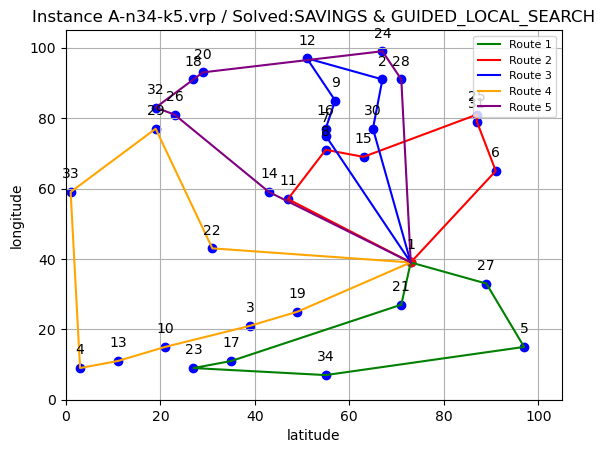

Soluzione ottima: 778
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 786
Gap: 1.0282776349614395%
Tempo di esecuzione: 2.000000238418579s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 790
Gap: 1.5424164524421593%
Tempo di esecuzione: 2.0009992122650146s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 832
Gap: 6.940874035989718%
Tempo di esecuzione: 2.0010013580322266s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 786
Gap: 1.0282776349614395%
Tempo di esecuzione: 1.9999728202819824s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 786
Gap: 1.0282776349614395%
Tempo di esecuzione: 1.

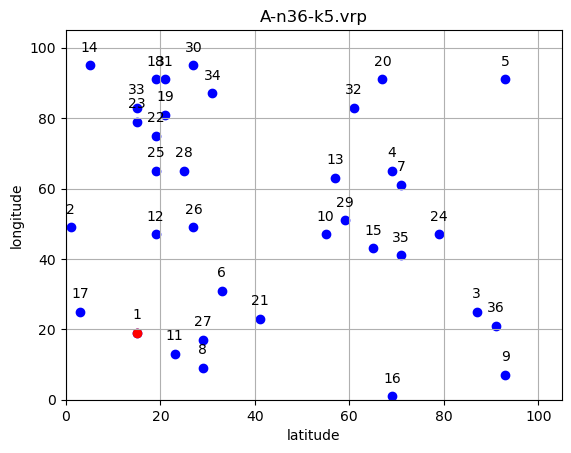

Soluzione ottima: 799
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 869
Route for vehicle 1:
 1 Load(0) ->  27 Load(13) ->  8 Load(35) ->  11 Load(58) ->  0 Load(58)
Distance of the route: 39m
Load of the route: 58

Route for vehicle 2:
 1 Load(0) ->  12 Load(12) ->  25 Load(25) ->  22 Load(40) ->  23 Load(51) ->  19 Load(70) ->  28 Load(78) ->  26 Load(97) ->  0 Load(97)
Distance of the route: 132m
Load of the route: 97

Route for vehicle 3:
 1 Load(0) ->  6 Load(18) ->  13 Load(39) ->  29 Load(54) ->  10 Load(72) ->  21 Load(92) ->  0 Load(92)
Distance of the route: 134m
Load of the route: 92

Route for vehicle 4:
 1 Load(0) ->  16 Load(9) ->  9 Load(16) ->  36 Load(27) ->  3 Load(41) ->  24 Load(47) ->  7 Load(49) ->  4 Load(64) ->  32 Load(85) ->  34 Load(87) ->  33 Load(99) ->  0 Load(99)
Distance of the route: 275m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  17 Load(10) ->  2 Load(11) ->  14 Load(13) ->  18 Load(17) ->  31 Load(

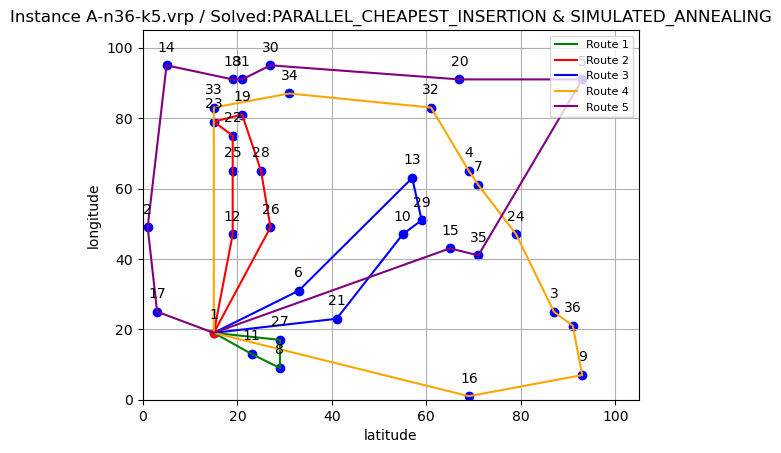

Local Search: TABU_SEARCH
Objective: 881
Route for vehicle 1:
 1 Load(0) ->  11 Load(23) ->  8 Load(45) ->  0 Load(45)
Distance of the route: 34m
Load of the route: 45

Route for vehicle 2:
 1 Load(0) ->  17 Load(10) ->  2 Load(11) ->  14 Load(13) ->  19 Load(32) ->  22 Load(47) ->  25 Load(60) ->  28 Load(68) ->  26 Load(87) ->  12 Load(99) ->  0 Load(99)
Distance of the route: 178m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  16 Load(9) ->  9 Load(16) ->  36 Load(27) ->  3 Load(41) ->  24 Load(47) ->  35 Load(70) ->  15 Load(84) ->  29 Load(99) ->  0 Load(99)
Distance of the route: 205m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  6 Load(18) ->  13 Load(39) ->  4 Load(54) ->  32 Load(75) ->  34 Load(77) ->  33 Load(89) ->  23 Load(100) ->  0 Load(100)
Distance of the route: 204m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  27 Load(13) ->  21 Load(33) ->  10 Load(51) ->  7 Load(53) ->  5 Load(64) ->  20 Load(66) ->  30 Load(84) ->  31 Load(95

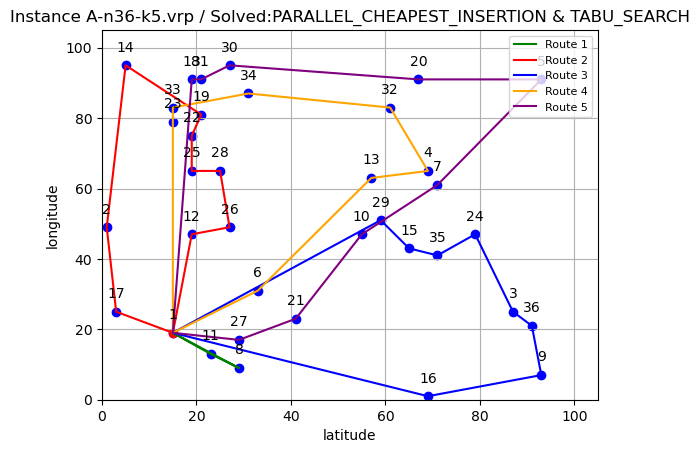

Local Search: GUIDED_LOCAL_SEARCH
Objective: 821
Route for vehicle 1:
 1 Load(0) ->  27 Load(13) ->  8 Load(35) ->  11 Load(58) ->  0 Load(58)
Distance of the route: 39m
Load of the route: 58

Route for vehicle 2:
 1 Load(0) ->  2 Load(1) ->  14 Load(3) ->  18 Load(7) ->  31 Load(18) ->  30 Load(36) ->  34 Load(38) ->  20 Load(40) ->  5 Load(51) ->  32 Load(72) ->  26 Load(91) ->  0 Load(91)
Distance of the route: 287m
Load of the route: 91

Route for vehicle 3:
 1 Load(0) ->  21 Load(20) ->  35 Load(43) ->  15 Load(57) ->  10 Load(75) ->  6 Load(93) ->  0 Load(93)
Distance of the route: 127m
Load of the route: 93

Route for vehicle 4:
 1 Load(0) ->  17 Load(10) ->  25 Load(23) ->  22 Load(38) ->  23 Load(49) ->  33 Load(61) ->  19 Load(80) ->  28 Load(88) ->  12 Load(100) ->  0 Load(100)
Distance of the route: 145m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  16 Load(9) ->  9 Load(16) ->  36 Load(27) ->  3 Load(41) ->  24 Load(47) ->  7 Load(49) ->  4 Load(64) ->  13 Lo

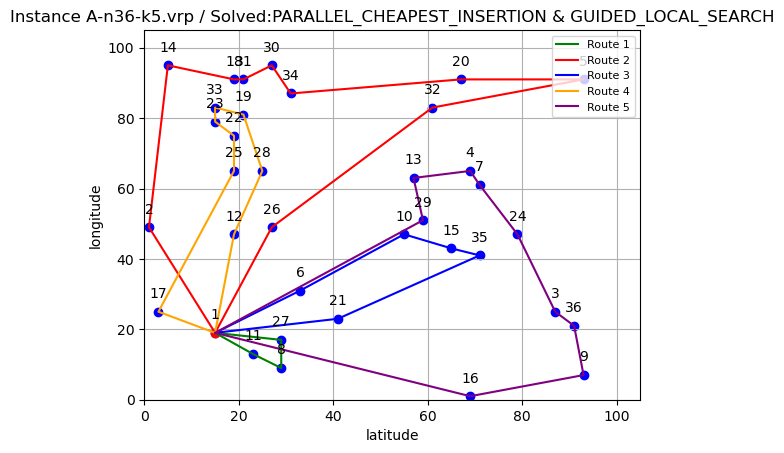

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 890
Route for vehicle 1:
 1 Load(0) ->  27 Load(13) ->  8 Load(35) ->  11 Load(58) ->  0 Load(58)
Distance of the route: 39m
Load of the route: 58

Route for vehicle 2:
 1 Load(0) ->  12 Load(12) ->  25 Load(25) ->  22 Load(40) ->  19 Load(59) ->  28 Load(67) ->  26 Load(86) ->  0 Load(86)
Distance of the route: 126m
Load of the route: 86

Route for vehicle 3:
 1 Load(0) ->  10 Load(18) ->  29 Load(33) ->  15 Load(47) ->  35 Load(70) ->  16 Load(79) ->  21 Load(99) ->  0 Load(99)
Distance of the route: 173m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  6 Load(18) ->  13 Load(39) ->  4 Load(54) ->  32 Load(75) ->  34 Load(77) ->  33 Load(89) ->  23 Load(100) ->  0 Load(100)
Distance of the route: 204m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  9 Load(7) ->  36 Load(18) ->  3 Load(32) ->  24 Load(38) ->  7 Load(40) ->  5 Load(51) ->  20 Load(53) ->  30 Load(71) ->  31 Load(82) ->  18 Load(86) -> 

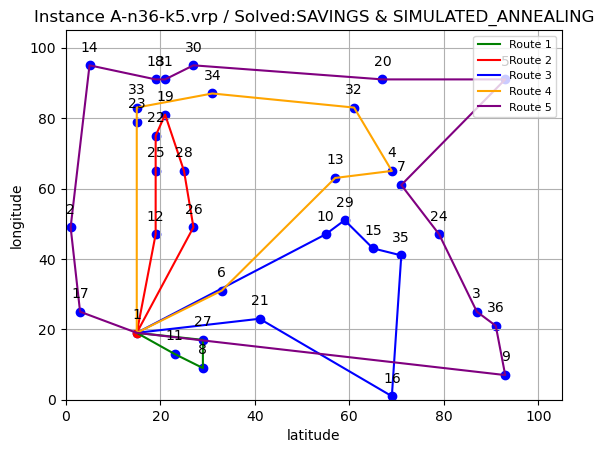

Local Search: TABU_SEARCH
Objective: 906
Route for vehicle 1:
 1 Load(0) ->  27 Load(13) ->  8 Load(35) ->  11 Load(58) ->  0 Load(58)
Distance of the route: 39m
Load of the route: 58

Route for vehicle 2:
 1 Load(0) ->  12 Load(12) ->  25 Load(25) ->  22 Load(40) ->  19 Load(59) ->  28 Load(67) ->  26 Load(86) ->  0 Load(86)
Distance of the route: 126m
Load of the route: 86

Route for vehicle 3:
 1 Load(0) ->  10 Load(18) ->  29 Load(33) ->  13 Load(54) ->  7 Load(56) ->  24 Load(62) ->  35 Load(85) ->  15 Load(99) ->  0 Load(99)
Distance of the route: 168m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  16 Load(9) ->  9 Load(16) ->  36 Load(27) ->  3 Load(41) ->  4 Load(56) ->  32 Load(77) ->  33 Load(89) ->  23 Load(100) ->  0 Load(100)
Distance of the route: 276m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  6 Load(18) ->  21 Load(38) ->  5 Load(49) ->  20 Load(51) ->  34 Load(53) ->  30 Load(71) ->  31 Load(82) ->  18 Load(86) ->  14 Load(88) ->  2 Load(89

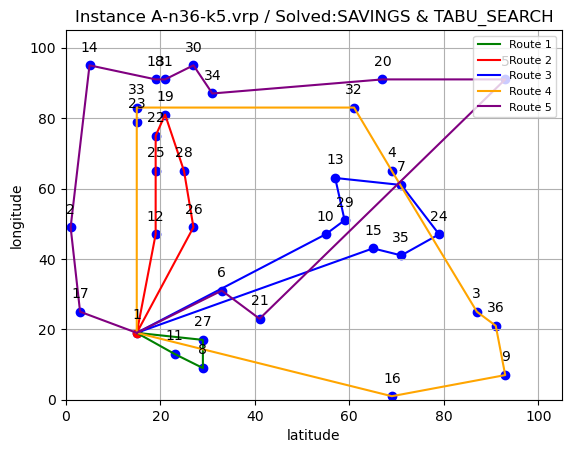

Local Search: GUIDED_LOCAL_SEARCH
Objective: 903
Route for vehicle 1:
 1 Load(0) ->  8 Load(22) ->  11 Load(45) ->  0 Load(45)
Distance of the route: 34m
Load of the route: 45

Route for vehicle 2:
 1 Load(0) ->  27 Load(13) ->  21 Load(33) ->  6 Load(51) ->  26 Load(70) ->  28 Load(78) ->  12 Load(90) ->  17 Load(100) ->  0 Load(100)
Distance of the route: 132m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  15 Load(14) ->  35 Load(37) ->  24 Load(43) ->  13 Load(64) ->  29 Load(79) ->  10 Load(97) ->  0 Load(97)
Distance of the route: 165m
Load of the route: 97

Route for vehicle 4:
 1 Load(0) ->  16 Load(9) ->  9 Load(16) ->  36 Load(27) ->  3 Load(41) ->  4 Load(56) ->  32 Load(77) ->  33 Load(89) ->  23 Load(100) ->  0 Load(100)
Distance of the route: 276m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  2 Load(1) ->  25 Load(14) ->  22 Load(29) ->  19 Load(48) ->  14 Load(50) ->  18 Load(54) ->  31 Load(65) ->  30 Load(83) ->  34 Load(85) ->  20 Load(87) ->

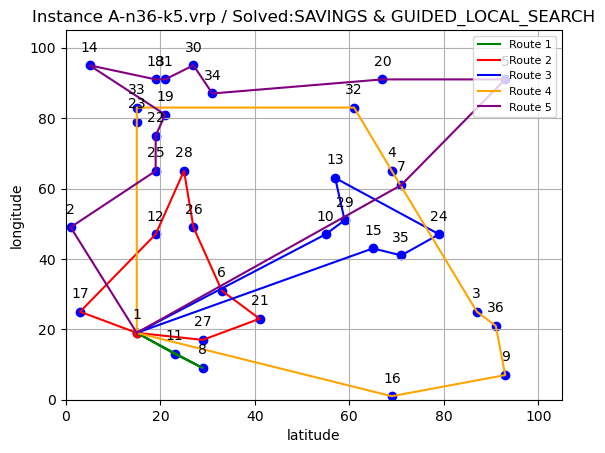

Soluzione ottima: 799
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 869
Gap: 8.760951188986233%
Tempo di esecuzione: 1.9999988079071045s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 881
Gap: 10.262828535669586%
Tempo di esecuzione: 2.0010063648223877s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 821
Gap: 2.753441802252816%
Tempo di esecuzione: 2.0000014305114746s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 890
Gap: 11.389236545682103%
Tempo di esecuzione: 2.000007390975952s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 906
Gap: 13.391739674593243%
Tempo di esecuzione: 2.0

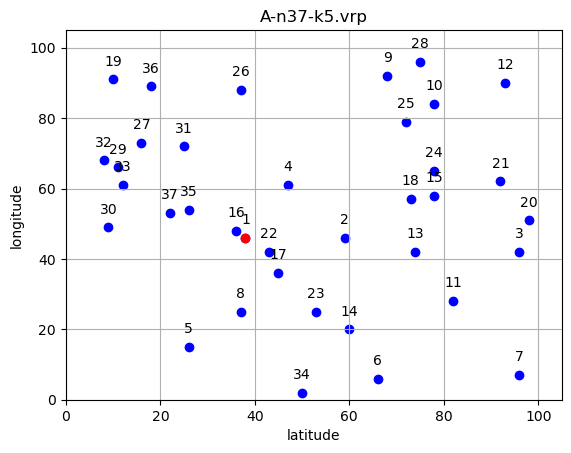

Soluzione ottima: 669
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 669
Route for vehicle 1:
 1 Load(0) ->  22 Load(23) ->  17 Load(39) ->  0 Load(39)
Distance of the route: 24m
Load of the route: 39

Route for vehicle 2:
 1 Load(0) ->  8 Load(7) ->  5 Load(20) ->  34 Load(27) ->  6 Load(35) ->  7 Load(58) ->  11 Load(61) ->  14 Load(80) ->  23 Load(96) ->  0 Load(96)
Distance of the route: 192m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  16 Load(5) ->  31 Load(28) ->  32 Load(34) ->  29 Load(35) ->  33 Load(54) ->  30 Load(63) ->  37 Load(83) ->  0 Load(83)
Distance of the route: 98m
Load of the route: 83

Route for vehicle 4:
 1 Load(0) ->  2 Load(16) ->  13 Load(40) ->  3 Load(58) ->  20 Load(80) ->  21 Load(87) ->  24 Load(89) ->  15 Load(91) ->  18 Load(98) ->  0 Load(98)
Distance of the route: 144m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  35 Load(7) ->  27 Load(9) ->  19 Load(13) ->  36 Load(33) ->  26 Load(42)

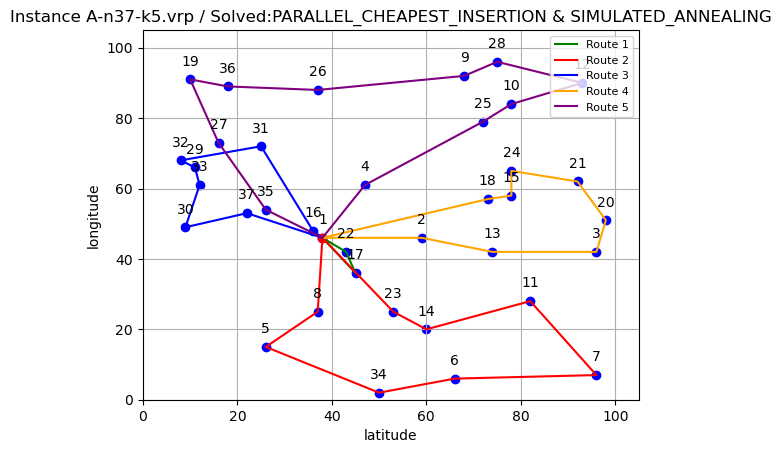

Local Search: TABU_SEARCH
Objective: 670
Route for vehicle 1:
 1 Load(0) ->  17 Load(16) ->  22 Load(39) ->  0 Load(39)
Distance of the route: 24m
Load of the route: 39

Route for vehicle 2:
 1 Load(0) ->  18 Load(7) ->  15 Load(9) ->  24 Load(11) ->  21 Load(18) ->  20 Load(40) ->  3 Load(58) ->  13 Load(82) ->  2 Load(98) ->  0 Load(98)
Distance of the route: 144m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  16 Load(5) ->  31 Load(28) ->  27 Load(30) ->  32 Load(36) ->  29 Load(37) ->  33 Load(56) ->  30 Load(65) ->  37 Load(85) ->  35 Load(92) ->  0 Load(92)
Distance of the route: 100m
Load of the route: 92

Route for vehicle 4:
 1 Load(0) ->  8 Load(7) ->  5 Load(20) ->  34 Load(27) ->  6 Load(35) ->  7 Load(58) ->  11 Load(61) ->  14 Load(80) ->  23 Load(96) ->  0 Load(96)
Distance of the route: 192m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  19 Load(4) ->  36 Load(24) ->  26 Load(33) ->  9 Load(60) ->  28 Load(72) ->  12 Load(78) ->  10 Load(79) ->  

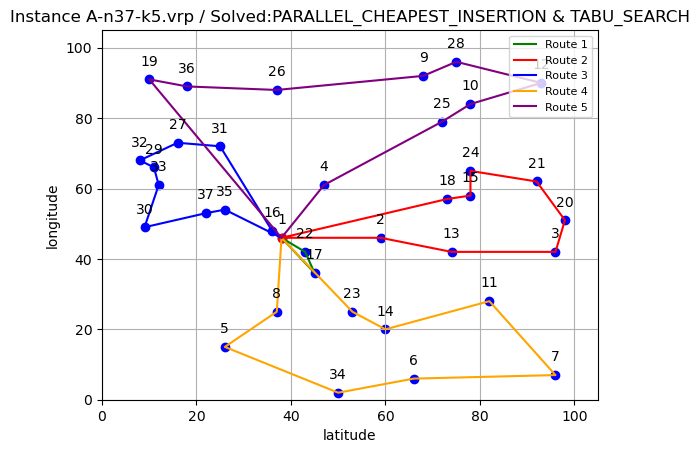

Local Search: GUIDED_LOCAL_SEARCH
Objective: 781
Route for vehicle 1:
 1 Load(0) ->  35 Load(7) ->  30 Load(16) ->  8 Load(23) ->  34 Load(30) ->  14 Load(49) ->  23 Load(65) ->  2 Load(81) ->  17 Load(97) ->  0 Load(97)
Distance of the route: 176m
Load of the route: 97

Route for vehicle 2:
 1 Load(0) ->  22 Load(23) ->  0 Load(23)
Distance of the route: 12m
Load of the route: 23

Route for vehicle 3:
 1 Load(0) ->  16 Load(5) ->  31 Load(28) ->  36 Load(48) ->  19 Load(52) ->  27 Load(54) ->  32 Load(60) ->  29 Load(61) ->  33 Load(80) ->  37 Load(100) ->  0 Load(100)
Distance of the route: 122m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  5 Load(13) ->  6 Load(21) ->  7 Load(44) ->  11 Load(47) ->  15 Load(49) ->  25 Load(51) ->  10 Load(52) ->  28 Load(64) ->  9 Load(91) ->  26 Load(100) ->  0 Load(100)
Distance of the route: 282m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  4 Load(1) ->  18 Load(8) ->  24 Load(10) ->  12 Load(16) ->  21 Load(23) ->  2

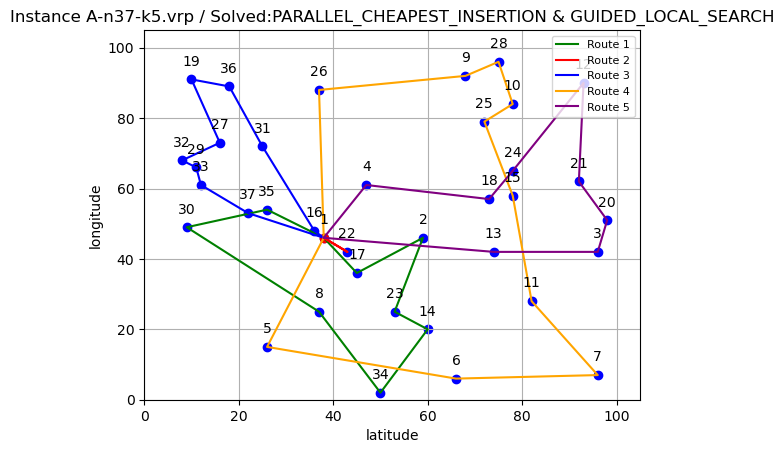

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 754
Route for vehicle 1:
 1 Load(0) ->  8 Load(7) ->  14 Load(26) ->  23 Load(42) ->  17 Load(58) ->  22 Load(81) ->  0 Load(81)
Distance of the route: 80m
Load of the route: 81

Route for vehicle 2:
 1 Load(0) ->  5 Load(13) ->  34 Load(20) ->  6 Load(28) ->  7 Load(51) ->  11 Load(54) ->  13 Load(78) ->  2 Load(94) ->  0 Load(94)
Distance of the route: 184m
Load of the route: 94

Route for vehicle 3:
 1 Load(0) ->  25 Load(2) ->  10 Load(3) ->  12 Load(9) ->  26 Load(18) ->  36 Load(38) ->  19 Load(42) ->  27 Load(44) ->  32 Load(50) ->  29 Load(51) ->  33 Load(70) ->  30 Load(79) ->  37 Load(99) ->  0 Load(99)
Distance of the route: 234m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  18 Load(7) ->  15 Load(9) ->  3 Load(27) ->  20 Load(49) ->  21 Load(56) ->  24 Load(58) ->  28 Load(70) ->  9 Load(97) ->  4 Load(98) ->  0 Load(98)
Distance of the route: 195m
Load of the route: 98

Route for vehicle 5:
 1 Load

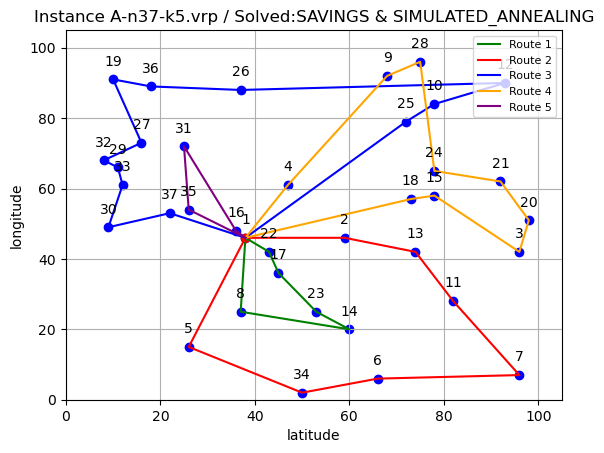

Local Search: TABU_SEARCH
Objective: 670
Route for vehicle 1:
 1 Load(0) ->  17 Load(16) ->  22 Load(39) ->  0 Load(39)
Distance of the route: 24m
Load of the route: 39

Route for vehicle 2:
 1 Load(0) ->  18 Load(7) ->  15 Load(9) ->  24 Load(11) ->  21 Load(18) ->  20 Load(40) ->  3 Load(58) ->  13 Load(82) ->  2 Load(98) ->  0 Load(98)
Distance of the route: 144m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  16 Load(5) ->  31 Load(28) ->  27 Load(30) ->  32 Load(36) ->  29 Load(37) ->  33 Load(56) ->  30 Load(65) ->  37 Load(85) ->  35 Load(92) ->  0 Load(92)
Distance of the route: 100m
Load of the route: 92

Route for vehicle 4:
 1 Load(0) ->  8 Load(7) ->  5 Load(20) ->  34 Load(27) ->  6 Load(35) ->  7 Load(58) ->  11 Load(61) ->  14 Load(80) ->  23 Load(96) ->  0 Load(96)
Distance of the route: 192m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  19 Load(4) ->  36 Load(24) ->  26 Load(33) ->  9 Load(60) ->  28 Load(72) ->  12 Load(78) ->  10 Load(79) ->  

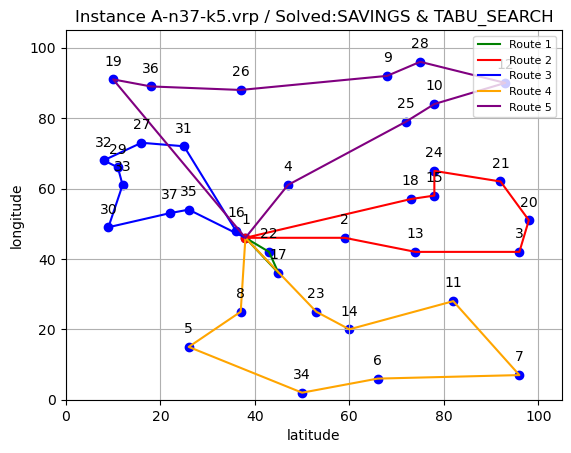

Local Search: GUIDED_LOCAL_SEARCH
Objective: 704
Route for vehicle 1:
 1 Load(0) ->  5 Load(13) ->  14 Load(32) ->  23 Load(48) ->  17 Load(64) ->  22 Load(87) ->  0 Load(87)
Distance of the route: 102m
Load of the route: 87

Route for vehicle 2:
 1 Load(0) ->  18 Load(7) ->  15 Load(9) ->  21 Load(16) ->  20 Load(38) ->  3 Load(56) ->  13 Load(80) ->  2 Load(96) ->  0 Load(96)
Distance of the route: 138m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  35 Load(7) ->  37 Load(27) ->  0 Load(27)
Distance of the route: 35m
Load of the route: 27

Route for vehicle 4:
 1 Load(0) ->  8 Load(7) ->  34 Load(14) ->  6 Load(22) ->  7 Load(45) ->  11 Load(48) ->  24 Load(50) ->  25 Load(52) ->  10 Load(53) ->  12 Load(59) ->  28 Load(71) ->  9 Load(98) ->  4 Load(99) ->  0 Load(99)
Distance of the route: 275m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  16 Load(5) ->  31 Load(28) ->  26 Load(37) ->  36 Load(57) ->  19 Load(61) ->  27 Load(63) ->  32 Load(69) ->  29 Load(7

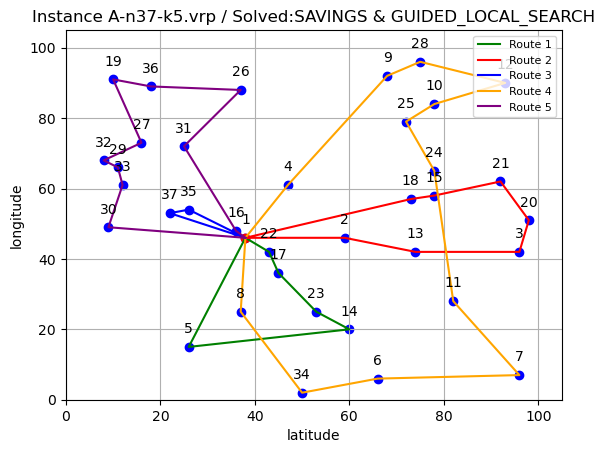

Soluzione ottima: 669
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 669
Gap: 0.0%
Tempo di esecuzione: 1.9999995231628418s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 670
Gap: 0.14947683109118087%
Tempo di esecuzione: 1.999950885772705s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 781
Gap: 16.741405082212257%
Tempo di esecuzione: 1.999999761581421s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 754
Gap: 12.705530642750373%
Tempo di esecuzione: 2.0000085830688477s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 670
Gap: 0.14947683109118087%
Tempo di esecuzione: 1.9999928474426

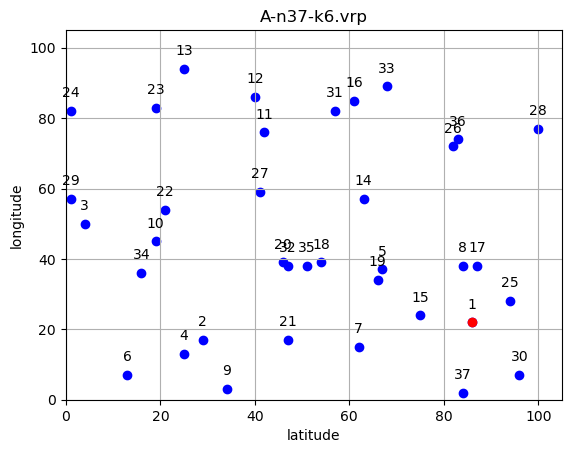

Soluzione ottima: 949
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 1005
Route for vehicle 1:
 1 Load(0) ->  32 Load(21) ->  20 Load(31) ->  18 Load(45) ->  5 Load(50) ->  8 Load(62) ->  17 Load(79) ->  25 Load(97) ->  0 Load(97)
Distance of the route: 106m
Load of the route: 97

Route for vehicle 2:
 1 Load(0) ->  30 Load(18) ->  37 Load(39) ->  7 Load(57) ->  19 Load(65) ->  15 Load(78) ->  0 Load(78)
Distance of the route: 100m
Load of the route: 78

Route for vehicle 3:
 1 Load(0) ->  21 Load(5) ->  2 Load(6) ->  3 Load(29) ->  29 Load(32) ->  24 Load(41) ->  23 Load(53) ->  13 Load(55) ->  11 Load(74) ->  14 Load(100) ->  0 Load(100)
Distance of the route: 257m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  26 Load(4) ->  36 Load(70) ->  33 Load(91) ->  28 Load(99) ->  0 Load(99)
Distance of the route: 164m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  9 Load(20) ->  4 Load(43) ->  6 Load(50) ->  34 Load(58) ->  10 Loa

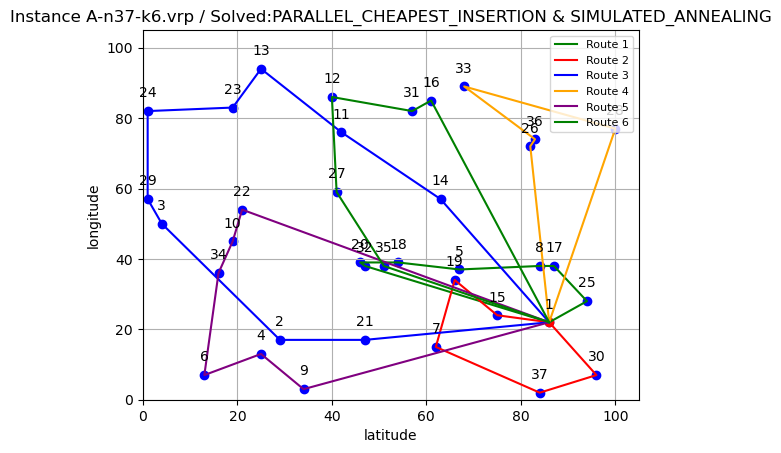

Local Search: TABU_SEARCH
Objective: 1090
Route for vehicle 1:
 1 Load(0) ->  37 Load(21) ->  30 Load(39) ->  25 Load(57) ->  17 Load(74) ->  0 Load(74)
Distance of the route: 82m
Load of the route: 74

Route for vehicle 2:
 1 Load(0) ->  28 Load(8) ->  33 Load(29) ->  36 Load(95) ->  26 Load(99) ->  0 Load(99)
Distance of the route: 164m
Load of the route: 99

Route for vehicle 3:
 1 Load(0) ->  7 Load(18) ->  21 Load(23) ->  2 Load(24) ->  34 Load(32) ->  12 Load(48) ->  11 Load(67) ->  27 Load(87) ->  20 Load(97) ->  0 Load(97)
Distance of the route: 227m
Load of the route: 97

Route for vehicle 4:
 1 Load(0) ->  15 Load(13) ->  5 Load(18) ->  3 Load(41) ->  29 Load(44) ->  24 Load(53) ->  13 Load(55) ->  31 Load(81) ->  16 Load(100) ->  0 Load(100)
Distance of the route: 257m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  9 Load(20) ->  4 Load(43) ->  6 Load(50) ->  10 Load(69) ->  22 Load(88) ->  23 Load(100) ->  0 Load(100)
Distance of the route: 248m
Load of the rou

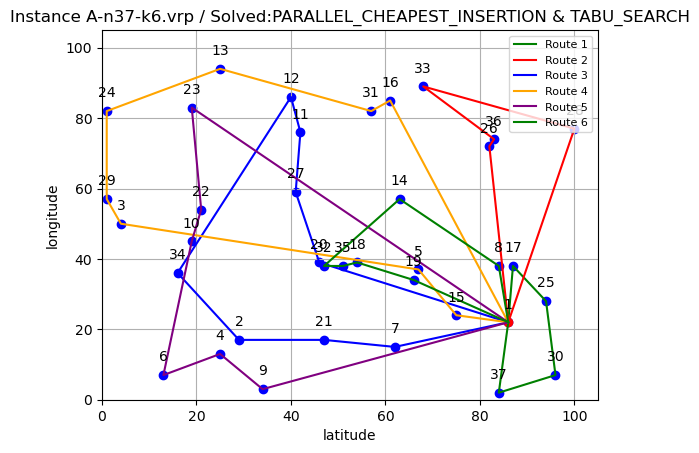

Local Search: GUIDED_LOCAL_SEARCH
Objective: 1001
Route for vehicle 1:
 1 Load(0) ->  8 Load(12) ->  17 Load(29) ->  25 Load(47) ->  30 Load(65) ->  37 Load(86) ->  0 Load(86)
Distance of the route: 85m
Load of the route: 86

Route for vehicle 2:
 1 Load(0) ->  7 Load(18) ->  32 Load(39) ->  20 Load(49) ->  35 Load(68) ->  18 Load(82) ->  15 Load(95) ->  0 Load(95)
Distance of the route: 98m
Load of the route: 95

Route for vehicle 3:
 1 Load(0) ->  21 Load(5) ->  34 Load(13) ->  3 Load(36) ->  29 Load(39) ->  24 Load(48) ->  11 Load(67) ->  14 Load(93) ->  0 Load(93)
Distance of the route: 237m
Load of the route: 93

Route for vehicle 4:
 1 Load(0) ->  26 Load(4) ->  36 Load(70) ->  33 Load(91) ->  28 Load(99) ->  0 Load(99)
Distance of the route: 164m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  9 Load(20) ->  6 Load(27) ->  4 Load(50) ->  2 Load(51) ->  10 Load(70) ->  22 Load(89) ->  19 Load(97) ->  0 Load(97)
Distance of the route: 206m
Load of the route: 97

Route f

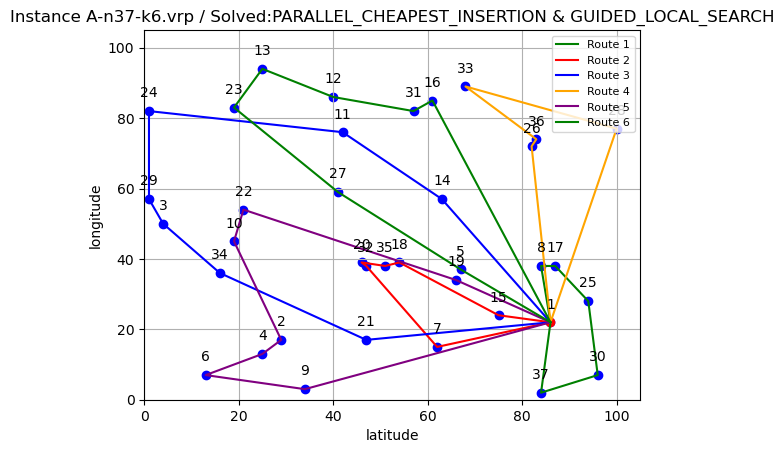

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 1004
Route for vehicle 1:
 1 Load(0) ->  8 Load(12) ->  17 Load(29) ->  25 Load(47) ->  30 Load(65) ->  37 Load(86) ->  0 Load(86)
Distance of the route: 85m
Load of the route: 86

Route for vehicle 2:
 1 Load(0) ->  3 Load(23) ->  29 Load(26) ->  24 Load(35) ->  13 Load(37) ->  12 Load(53) ->  31 Load(79) ->  16 Load(98) ->  0 Load(98)
Distance of the route: 254m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  15 Load(13) ->  19 Load(21) ->  18 Load(35) ->  35 Load(54) ->  32 Load(75) ->  7 Load(93) ->  0 Load(93)
Distance of the route: 96m
Load of the route: 93

Route for vehicle 4:
 1 Load(0) ->  14 Load(26) ->  11 Load(45) ->  23 Load(57) ->  22 Load(76) ->  27 Load(96) ->  0 Load(96)
Distance of the route: 202m
Load of the route: 96

Route for vehicle 5:
 1 Load(0) ->  21 Load(5) ->  9 Load(25) ->  2 Load(26) ->  4 Load(49) ->  6 Load(56) ->  34 Load(64) ->  10 Load(83) ->  20 Load(93) ->  5 Load(98) ->  0 L

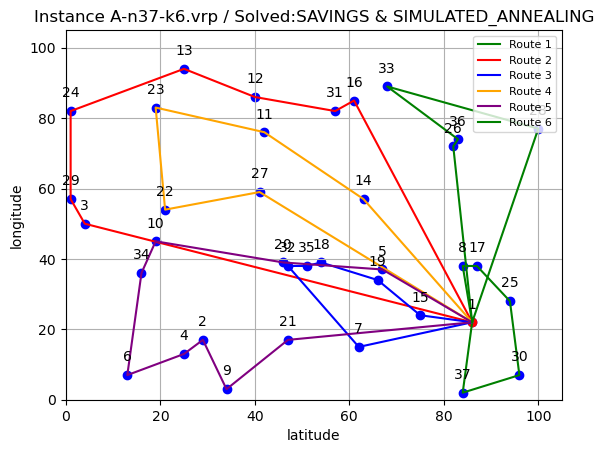

Local Search: TABU_SEARCH
Objective: 1044
Route for vehicle 1:
 1 Load(0) ->  19 Load(8) ->  32 Load(29) ->  20 Load(39) ->  18 Load(53) ->  8 Load(65) ->  17 Load(82) ->  25 Load(100) ->  0 Load(100)
Distance of the route: 106m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  30 Load(18) ->  37 Load(39) ->  7 Load(57) ->  35 Load(76) ->  0 Load(76)
Distance of the route: 120m
Load of the route: 76

Route for vehicle 3:
 1 Load(0) ->  15 Load(13) ->  21 Load(18) ->  2 Load(19) ->  3 Load(42) ->  29 Load(45) ->  24 Load(54) ->  11 Load(73) ->  14 Load(99) ->  0 Load(99)
Distance of the route: 243m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  26 Load(4) ->  36 Load(70) ->  33 Load(91) ->  28 Load(99) ->  0 Load(99)
Distance of the route: 164m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  9 Load(20) ->  4 Load(43) ->  6 Load(50) ->  34 Load(58) ->  10 Load(77) ->  22 Load(96) ->  0 Load(96)
Distance of the route: 200m
Load of the route: 96

Route for 

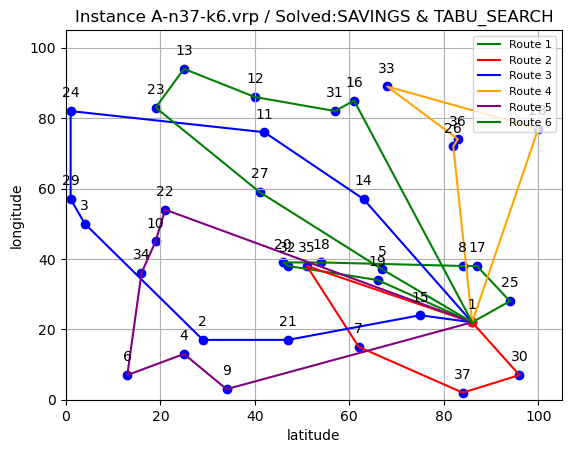

Local Search: GUIDED_LOCAL_SEARCH
Objective: 1034
Route for vehicle 1:
 1 Load(0) ->  8 Load(12) ->  17 Load(29) ->  25 Load(47) ->  30 Load(65) ->  37 Load(86) ->  0 Load(86)
Distance of the route: 85m
Load of the route: 86

Route for vehicle 2:
 1 Load(0) ->  15 Load(13) ->  19 Load(21) ->  18 Load(35) ->  35 Load(54) ->  32 Load(75) ->  7 Load(93) ->  0 Load(93)
Distance of the route: 96m
Load of the route: 93

Route for vehicle 3:
 1 Load(0) ->  14 Load(26) ->  27 Load(46) ->  11 Load(65) ->  23 Load(77) ->  34 Load(85) ->  20 Load(95) ->  0 Load(95)
Distance of the route: 225m
Load of the route: 95

Route for vehicle 4:
 1 Load(0) ->  26 Load(4) ->  36 Load(70) ->  33 Load(91) ->  28 Load(99) ->  0 Load(99)
Distance of the route: 164m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  21 Load(5) ->  9 Load(25) ->  6 Load(32) ->  4 Load(55) ->  2 Load(56) ->  10 Load(75) ->  22 Load(94) ->  5 Load(99) ->  0 Load(99)
Distance of the route: 210m
Load of the route: 99

Route f

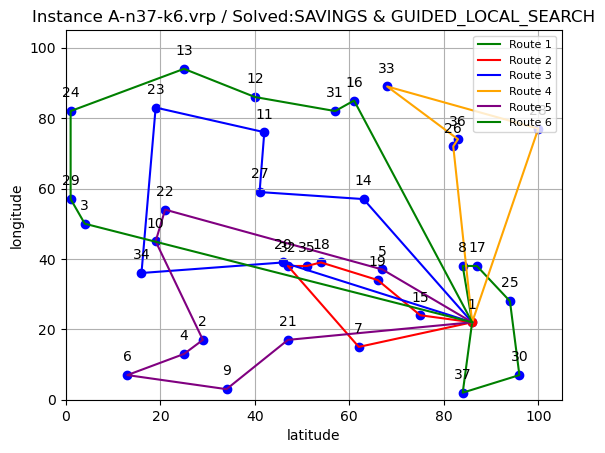

Soluzione ottima: 949
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 1005
Gap: 5.900948366701791%
Tempo di esecuzione: 2.00000262260437s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 1090
Gap: 14.857744994731295%
Tempo di esecuzione: 1.9989697933197021s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 1001
Gap: 5.47945205479452%
Tempo di esecuzione: 2.0009989738464355s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 1004
Gap: 5.795574288724974%
Tempo di esecuzione: 1.9990005493164062s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 1044
Gap: 10.010537407797681%
Tempo di esecuzione: 2

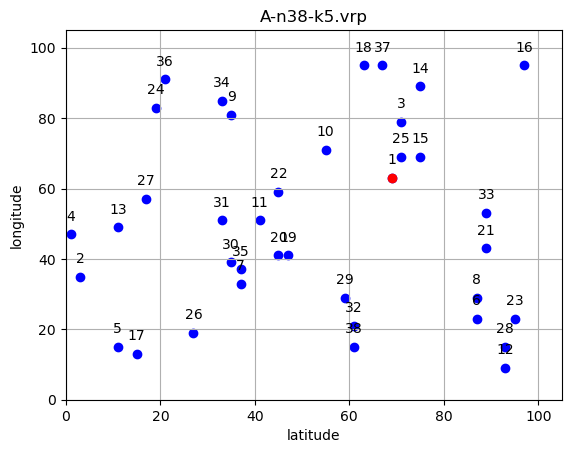

Soluzione ottima: 730
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 820
Route for vehicle 1:
 1 Load(0) ->  25 Load(8) ->  3 Load(13) ->  16 Load(26) ->  14 Load(31) ->  37 Load(45) ->  18 Load(58) ->  9 Load(77) ->  10 Load(100) ->  0 Load(100)
Distance of the route: 153m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(17) ->  33 Load(20) ->  23 Load(40) ->  28 Load(52) ->  12 Load(77) ->  6 Load(95) ->  0 Load(95)
Distance of the route: 133m
Load of the route: 95

Route for vehicle 3:
 1 Load(0) ->  22 Load(9) ->  31 Load(34) ->  27 Load(47) ->  13 Load(48) ->  4 Load(56) ->  24 Load(77) ->  36 Load(90) ->  34 Load(92) ->  0 Load(92)
Distance of the route: 178m
Load of the route: 92

Route for vehicle 4:
 1 Load(0) ->  19 Load(19) ->  20 Load(24) ->  26 Load(36) ->  7 Load(48) ->  35 Load(72) ->  30 Load(91) ->  11 Load(99) ->  0 Load(99)
Distance of the route: 128m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  21 

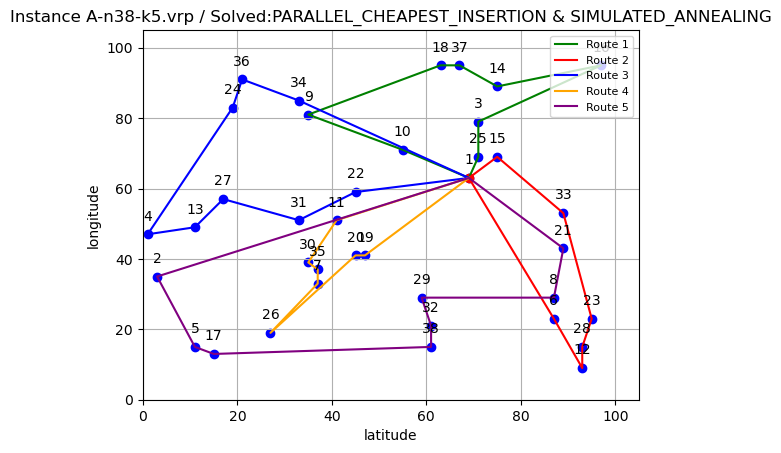

Local Search: TABU_SEARCH
Objective: 821
Route for vehicle 1:
 1 Load(0) ->  15 Load(17) ->  33 Load(20) ->  6 Load(38) ->  38 Load(52) ->  32 Load(59) ->  29 Load(63) ->  26 Load(75) ->  17 Load(84) ->  5 Load(96) ->  0 Load(96)
Distance of the route: 226m
Load of the route: 96

Route for vehicle 2:
 1 Load(0) ->  21 Load(26) ->  23 Load(46) ->  28 Load(58) ->  12 Load(83) ->  8 Load(94) ->  0 Load(94)
Distance of the route: 122m
Load of the route: 94

Route for vehicle 3:
 1 Load(0) ->  22 Load(9) ->  11 Load(17) ->  30 Load(36) ->  35 Load(60) ->  7 Load(72) ->  20 Load(77) ->  19 Load(96) ->  0 Load(96)
Distance of the route: 97m
Load of the route: 96

Route for vehicle 4:
 1 Load(0) ->  3 Load(5) ->  14 Load(10) ->  16 Load(23) ->  37 Load(37) ->  18 Load(50) ->  10 Load(73) ->  31 Load(98) ->  0 Load(98)
Distance of the route: 177m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  25 Load(8) ->  9 Load(27) ->  34 Load(29) ->  36 Load(42) ->  24 Load(63) ->  27 Load(76) -

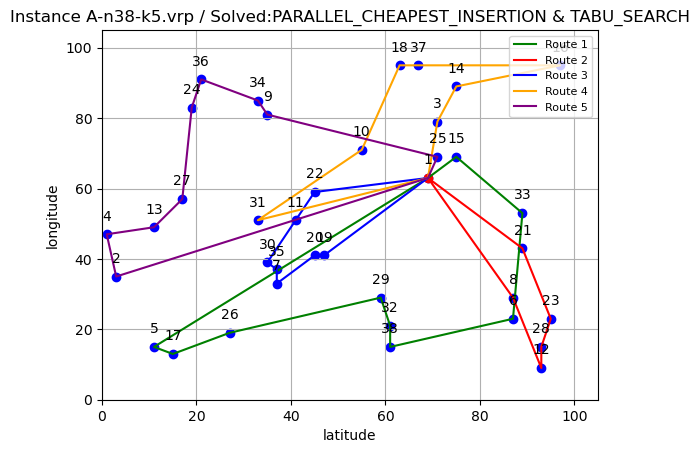

Local Search: GUIDED_LOCAL_SEARCH
Objective: 832
Route for vehicle 1:
 1 Load(0) ->  9 Load(19) ->  34 Load(21) ->  36 Load(34) ->  24 Load(55) ->  27 Load(68) ->  4 Load(76) ->  13 Load(77) ->  11 Load(85) ->  22 Load(94) ->  0 Load(94)
Distance of the route: 181m
Load of the route: 94

Route for vehicle 2:
 1 Load(0) ->  19 Load(19) ->  20 Load(24) ->  30 Load(43) ->  35 Load(67) ->  7 Load(79) ->  32 Load(86) ->  29 Load(90) ->  0 Load(90)
Distance of the route: 120m
Load of the route: 90

Route for vehicle 3:
 1 Load(0) ->  6 Load(18) ->  12 Load(43) ->  28 Load(55) ->  23 Load(75) ->  15 Load(92) ->  25 Load(100) ->  0 Load(100)
Distance of the route: 133m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  3 Load(5) ->  16 Load(18) ->  14 Load(23) ->  37 Load(37) ->  18 Load(50) ->  10 Load(73) ->  31 Load(98) ->  0 Load(98)
Distance of the route: 177m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  33 Load(3) ->  21 Load(29) ->  8 Load(40) ->  38 Load(54) ->  

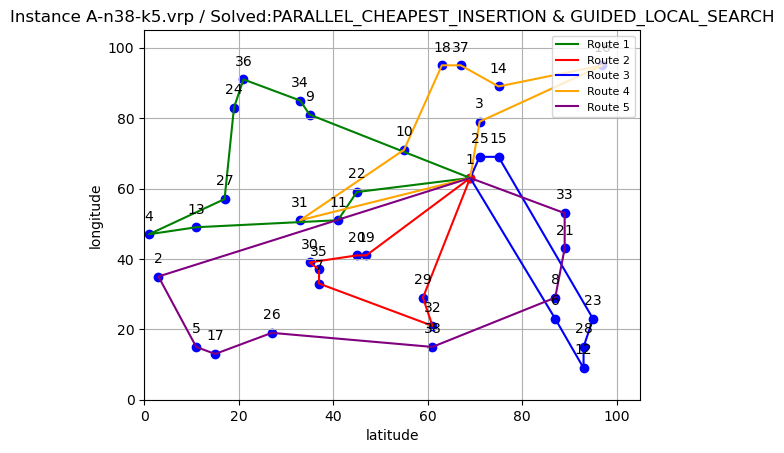

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 832
Route for vehicle 1:
 1 Load(0) ->  9 Load(19) ->  34 Load(21) ->  36 Load(34) ->  24 Load(55) ->  27 Load(68) ->  4 Load(76) ->  13 Load(77) ->  11 Load(85) ->  22 Load(94) ->  0 Load(94)
Distance of the route: 181m
Load of the route: 94

Route for vehicle 2:
 1 Load(0) ->  19 Load(19) ->  20 Load(24) ->  30 Load(43) ->  35 Load(67) ->  7 Load(79) ->  32 Load(86) ->  29 Load(90) ->  0 Load(90)
Distance of the route: 120m
Load of the route: 90

Route for vehicle 3:
 1 Load(0) ->  6 Load(18) ->  12 Load(43) ->  28 Load(55) ->  23 Load(75) ->  15 Load(92) ->  25 Load(100) ->  0 Load(100)
Distance of the route: 133m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  3 Load(5) ->  16 Load(18) ->  14 Load(23) ->  37 Load(37) ->  18 Load(50) ->  10 Load(73) ->  31 Load(98) ->  0 Load(98)
Distance of the route: 177m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  33 Load(3) ->  21 Load(29) ->  8 Load(40) ->

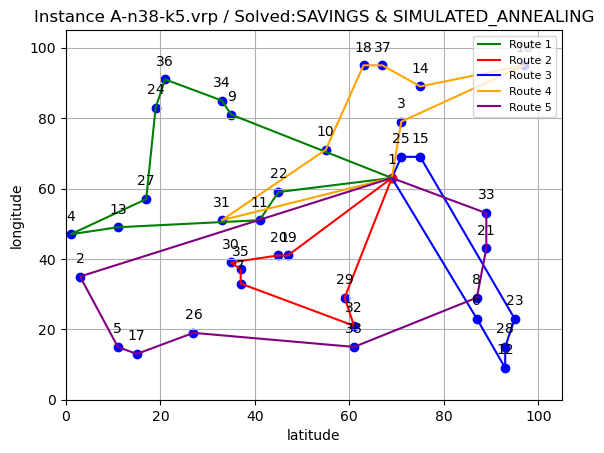

Local Search: TABU_SEARCH
Objective: 826
Route for vehicle 1:
 1 Load(0) ->  25 Load(8) ->  3 Load(13) ->  16 Load(26) ->  14 Load(31) ->  37 Load(45) ->  18 Load(58) ->  9 Load(77) ->  10 Load(100) ->  0 Load(100)
Distance of the route: 153m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  21 Load(26) ->  23 Load(46) ->  12 Load(71) ->  28 Load(83) ->  8 Load(94) ->  0 Load(94)
Distance of the route: 122m
Load of the route: 94

Route for vehicle 3:
 1 Load(0) ->  22 Load(9) ->  31 Load(34) ->  27 Load(47) ->  13 Load(48) ->  4 Load(56) ->  24 Load(77) ->  36 Load(90) ->  34 Load(92) ->  0 Load(92)
Distance of the route: 178m
Load of the route: 92

Route for vehicle 4:
 1 Load(0) ->  19 Load(19) ->  20 Load(24) ->  26 Load(36) ->  7 Load(48) ->  35 Load(72) ->  30 Load(91) ->  11 Load(99) ->  0 Load(99)
Distance of the route: 128m
Load of the route: 99

Route for vehicle 5:
 1 Load(0) ->  15 Load(17) ->  33 Load(20) ->  6 Load(38) ->  38 Load(52) ->  32 Load(59) ->  29 Load(

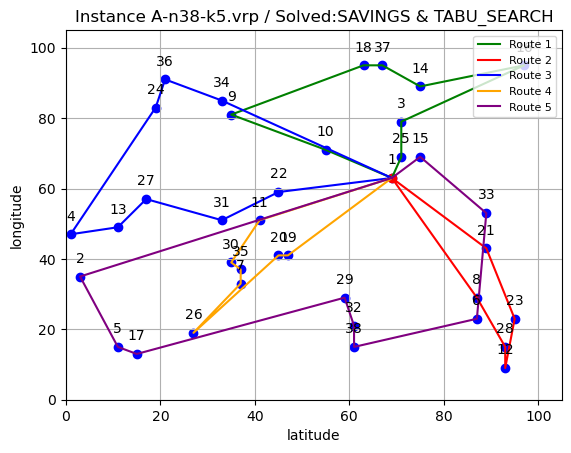

Local Search: GUIDED_LOCAL_SEARCH
Objective: 825
Route for vehicle 1:
 1 Load(0) ->  25 Load(8) ->  3 Load(13) ->  16 Load(26) ->  14 Load(31) ->  37 Load(45) ->  18 Load(58) ->  10 Load(81) ->  22 Load(90) ->  0 Load(90)
Distance of the route: 149m
Load of the route: 90

Route for vehicle 2:
 1 Load(0) ->  29 Load(4) ->  32 Load(11) ->  28 Load(23) ->  23 Load(43) ->  8 Load(54) ->  21 Load(80) ->  33 Load(83) ->  15 Load(100) ->  0 Load(100)
Distance of the route: 147m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  13 Load(1) ->  4 Load(9) ->  2 Load(21) ->  30 Load(40) ->  35 Load(64) ->  7 Load(76) ->  20 Load(81) ->  19 Load(100) ->  0 Load(100)
Distance of the route: 165m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  9 Load(19) ->  34 Load(21) ->  36 Load(34) ->  24 Load(55) ->  27 Load(68) ->  31 Load(93) ->  0 Load(93)
Distance of the route: 144m
Load of the route: 93

Route for vehicle 5:
 1 Load(0) ->  6 Load(18) ->  12 Load(43) ->  38 Load(57) ->  

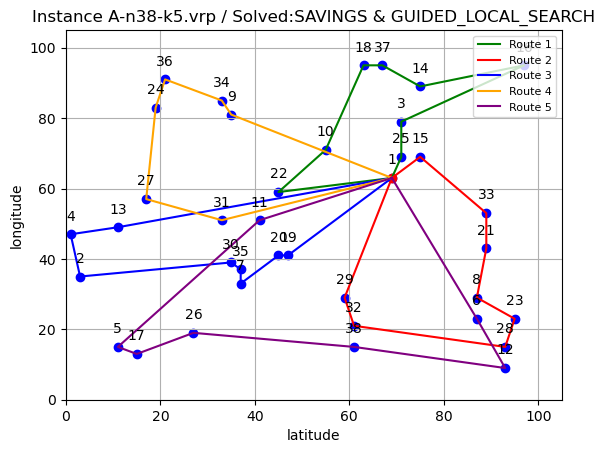

Soluzione ottima: 730
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 820
Gap: 12.32876712328767%
Tempo di esecuzione: 2.000000476837158s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 821
Gap: 12.465753424657535%
Tempo di esecuzione: 1.9999749660491943s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 832
Gap: 13.972602739726028%
Tempo di esecuzione: 2.0009706020355225s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 832
Gap: 13.972602739726028%
Tempo di esecuzione: 2.0010015964508057s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 826
Gap: 13.150684931506849%
Tempo di esecuzione: 2.

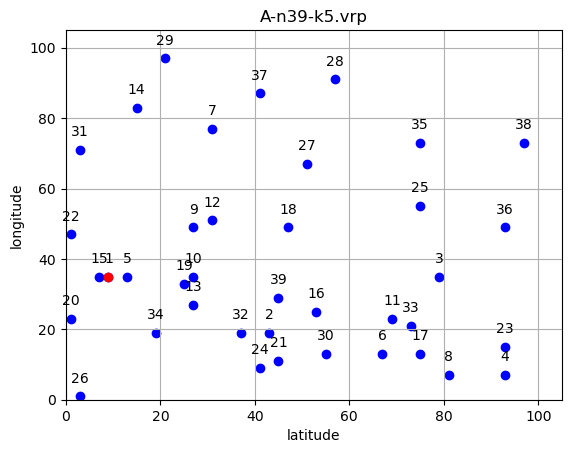

Soluzione ottima: 822
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 906
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  34 Load(22) ->  24 Load(38) ->  21 Load(41) ->  30 Load(47) ->  16 Load(61) ->  39 Load(68) ->  12 Load(77) ->  9 Load(80) ->  0 Load(80)
Distance of the route: 172m
Load of the route: 80

Route for vehicle 3:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) ->  29 Load(31) ->  7 Load(54) ->  37 Load(73) ->  35 Load(79) ->  27 Load(91) ->  18 Load(97) ->  0 Load(97)
Distance of the route: 226m
Load of the route: 97

Route for vehicle 4:
 1 Load(0) ->  32 Load(2) ->  2 Load(7) ->  6 Load(33) ->  8 Load(48) ->  4 Load(51) ->  23 Load(71) ->  33 Load(84) ->  11 Load(100) ->  0 Load(100)
Distance of the route: 184m
Load of the route: 100

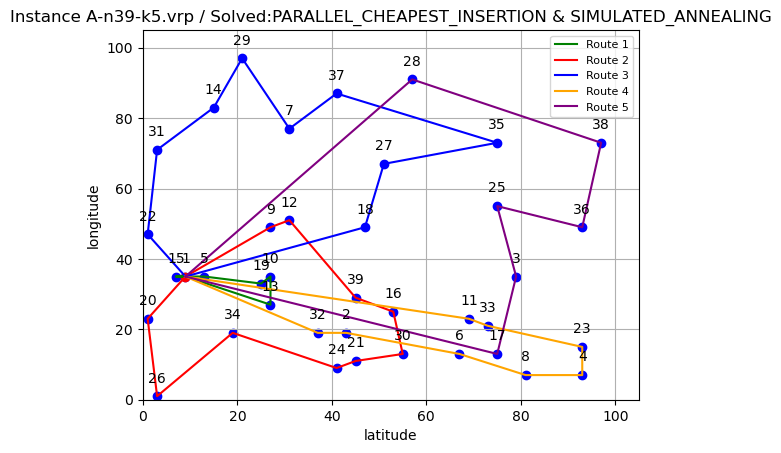

Local Search: TABU_SEARCH
Objective: 891
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  34 Load(22) ->  24 Load(38) ->  21 Load(41) ->  30 Load(47) ->  16 Load(61) ->  39 Load(68) ->  12 Load(77) ->  9 Load(80) ->  0 Load(80)
Distance of the route: 172m
Load of the route: 80

Route for vehicle 3:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) ->  29 Load(31) ->  37 Load(50) ->  28 Load(70) ->  38 Load(74) ->  35 Load(80) ->  27 Load(92) ->  18 Load(98) ->  0 Load(98)
Distance of the route: 257m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  11 Load(16) ->  33 Load(29) ->  23 Load(49) ->  4 Load(52) ->  8 Load(67) ->  6 Load(93) ->  2 Load(98) ->  32 Load(100) ->  0 Load(100)
Distance of the route: 184m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  7 Load(23) 

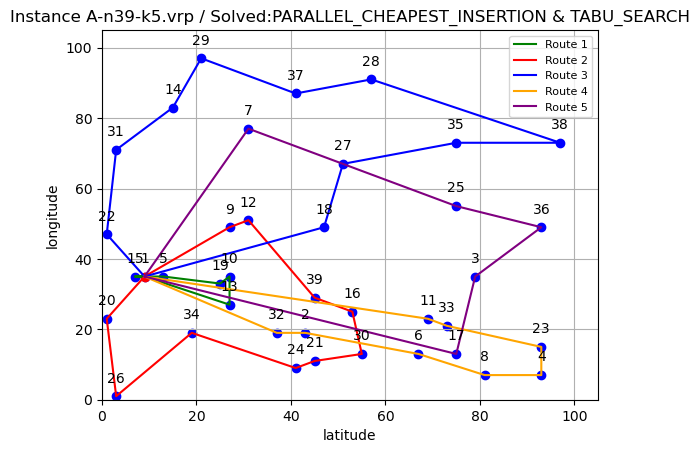

Local Search: GUIDED_LOCAL_SEARCH
Objective: 891
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  34 Load(22) ->  24 Load(38) ->  21 Load(41) ->  30 Load(47) ->  16 Load(61) ->  39 Load(68) ->  12 Load(77) ->  9 Load(80) ->  0 Load(80)
Distance of the route: 172m
Load of the route: 80

Route for vehicle 3:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) ->  29 Load(31) ->  37 Load(50) ->  28 Load(70) ->  38 Load(74) ->  35 Load(80) ->  27 Load(92) ->  18 Load(98) ->  0 Load(98)
Distance of the route: 257m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  11 Load(16) ->  33 Load(29) ->  23 Load(49) ->  4 Load(52) ->  8 Load(67) ->  6 Load(93) ->  2 Load(98) ->  32 Load(100) ->  0 Load(100)
Distance of the route: 184m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  7 L

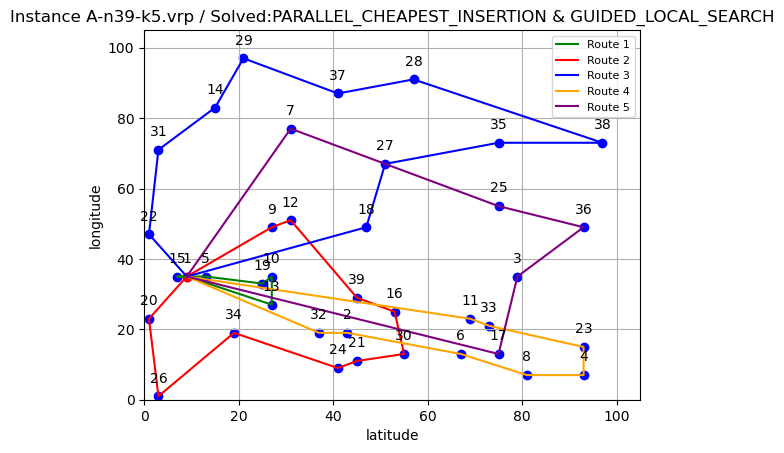

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 891
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  34 Load(22) ->  24 Load(38) ->  21 Load(41) ->  30 Load(47) ->  16 Load(61) ->  39 Load(68) ->  12 Load(77) ->  9 Load(80) ->  0 Load(80)
Distance of the route: 172m
Load of the route: 80

Route for vehicle 3:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) ->  29 Load(31) ->  37 Load(50) ->  28 Load(70) ->  38 Load(74) ->  35 Load(80) ->  27 Load(92) ->  18 Load(98) ->  0 Load(98)
Distance of the route: 257m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  11 Load(16) ->  33 Load(29) ->  23 Load(49) ->  4 Load(52) ->  8 Load(67) ->  6 Load(93) ->  2 Load(98) ->  32 Load(100) ->  0 Load(100)
Distance of the route: 184m
Load of the route: 100

Route for vehicle 5:


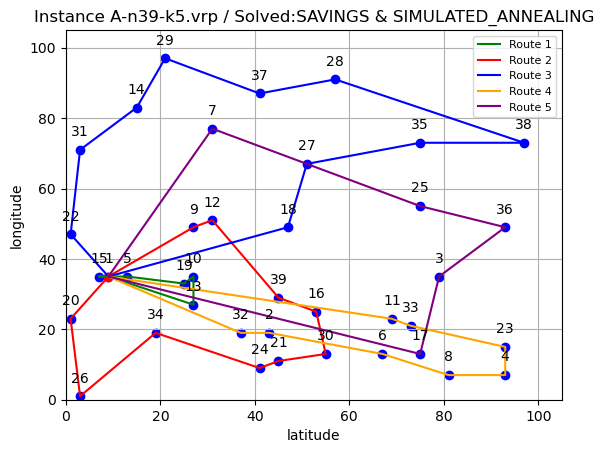

Local Search: TABU_SEARCH
Objective: 856
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  34 Load(22) ->  24 Load(38) ->  21 Load(41) ->  30 Load(47) ->  17 Load(53) ->  16 Load(67) ->  39 Load(74) ->  12 Load(83) ->  9 Load(86) ->  0 Load(86)
Distance of the route: 205m
Load of the route: 86

Route for vehicle 3:
 1 Load(0) ->  27 Load(12) ->  35 Load(18) ->  38 Load(22) ->  36 Load(46) ->  3 Load(70) ->  25 Load(92) ->  18 Load(98) ->  0 Load(98)
Distance of the route: 233m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  11 Load(16) ->  33 Load(29) ->  23 Load(49) ->  4 Load(52) ->  8 Load(67) ->  6 Load(93) ->  2 Load(98) ->  32 Load(100) ->  0 Load(100)
Distance of the route: 184m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) 

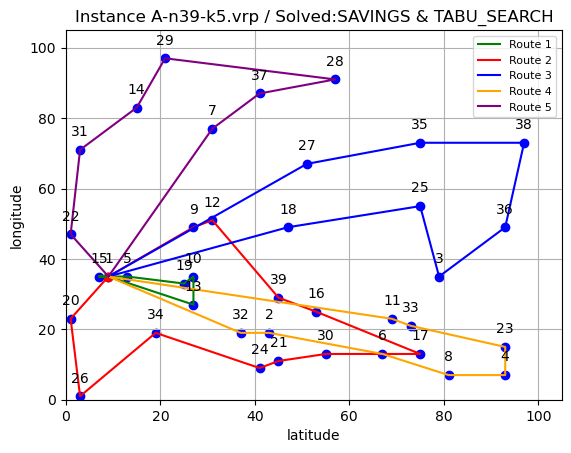

Local Search: GUIDED_LOCAL_SEARCH
Objective: 880
Route for vehicle 1:
 1 Load(0) ->  13 Load(21) ->  10 Load(41) ->  19 Load(54) ->  5 Load(74) ->  15 Load(98) ->  0 Load(98)
Distance of the route: 51m
Load of the route: 98

Route for vehicle 2:
 1 Load(0) ->  20 Load(5) ->  26 Load(15) ->  34 Load(22) ->  24 Load(38) ->  21 Load(41) ->  30 Load(47) ->  17 Load(53) ->  16 Load(67) ->  39 Load(74) ->  12 Load(83) ->  9 Load(86) ->  0 Load(86)
Distance of the route: 205m
Load of the route: 86

Route for vehicle 3:
 1 Load(0) ->  22 Load(3) ->  31 Load(4) ->  14 Load(7) ->  29 Load(31) ->  37 Load(50) ->  7 Load(73) ->  27 Load(85) ->  18 Load(91) ->  0 Load(91)
Distance of the route: 186m
Load of the route: 91

Route for vehicle 4:
 1 Load(0) ->  11 Load(16) ->  33 Load(29) ->  23 Load(49) ->  4 Load(52) ->  8 Load(67) ->  6 Load(93) ->  2 Load(98) ->  32 Load(100) ->  0 Load(100)
Distance of the route: 184m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  28 Load(20) ->  35 L

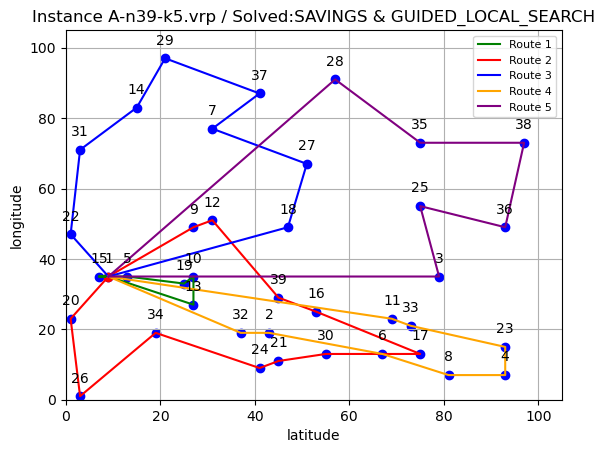

Soluzione ottima: 822
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 906
Gap: 10.218978102189782%
Tempo di esecuzione: 2.0000033378601074s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 891
Gap: 8.394160583941606%
Tempo di esecuzione: 2.0010056495666504s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 891
Gap: 8.394160583941606%
Tempo di esecuzione: 2.0000123977661133s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 891
Gap: 8.394160583941606%
Tempo di esecuzione: 1.999999761581421s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 856
Gap: 4.13625304136253%
Tempo di esecuzione: 1.9999

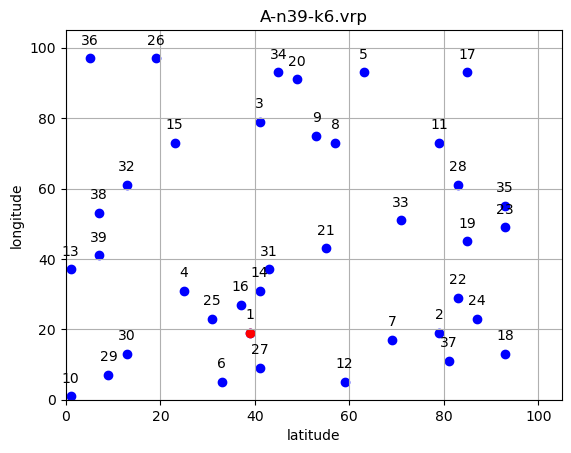

Soluzione ottima: 831
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 920
Route for vehicle 1:
 1 Load(0) ->  27 Load(15) ->  6 Load(18) ->  25 Load(40) ->  0 Load(40)
Distance of the route: 46m
Load of the route: 40

Route for vehicle 2:
 1 Load(0) ->  14 Load(72) ->  24 Load(73) ->  18 Load(77) ->  7 Load(96) ->  0 Load(96)
Distance of the route: 125m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  30 Load(22) ->  29 Load(27) ->  10 Load(33) ->  13 Load(49) ->  39 Load(51) ->  38 Load(61) ->  32 Load(71) ->  15 Load(78) ->  4 Load(100) ->  0 Load(100)
Distance of the route: 185m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  19 Load(22) ->  35 Load(25) ->  23 Load(36) ->  22 Load(47) ->  2 Load(65) ->  37 Load(80) ->  12 Load(98) ->  0 Load(98)
Distance of the route: 160m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  16 Load(16) ->  36 Load(23) ->  26 Load(39) ->  34 Load(48) ->  20 Load(71) ->  3 Load(87) ->  31

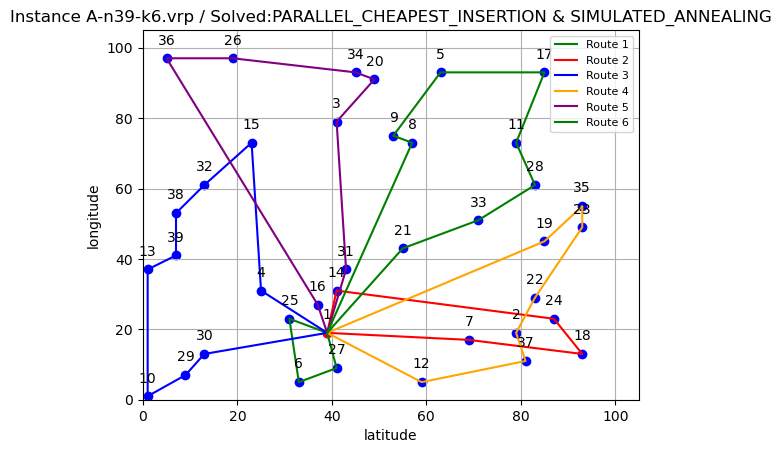

Local Search: TABU_SEARCH
Objective: 859
Route for vehicle 1:
 1 Load(0) ->  14 Load(72) ->  16 Load(88) ->  0 Load(88)
Distance of the route: 26m
Load of the route: 88

Route for vehicle 2:
 1 Load(0) ->  25 Load(22) ->  21 Load(29) ->  19 Load(51) ->  35 Load(54) ->  23 Load(65) ->  22 Load(76) ->  24 Load(77) ->  18 Load(81) ->  37 Load(96) ->  0 Load(96)
Distance of the route: 185m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  3 Load(16) ->  20 Load(39) ->  34 Load(48) ->  26 Load(64) ->  36 Load(71) ->  15 Load(78) ->  32 Load(88) ->  38 Load(98) ->  0 Load(98)
Distance of the route: 221m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  12 Load(18) ->  2 Load(36) ->  7 Load(55) ->  0 Load(55)
Distance of the route: 88m
Load of the route: 55

Route for vehicle 5:
 1 Load(0) ->  33 Load(11) ->  28 Load(18) ->  11 Load(30) ->  17 Load(53) ->  5 Load(77) ->  9 Load(83) ->  8 Load(89) ->  31 Load(98) ->  0 Load(98)
Distance of the route: 199m
Load of the route: 9

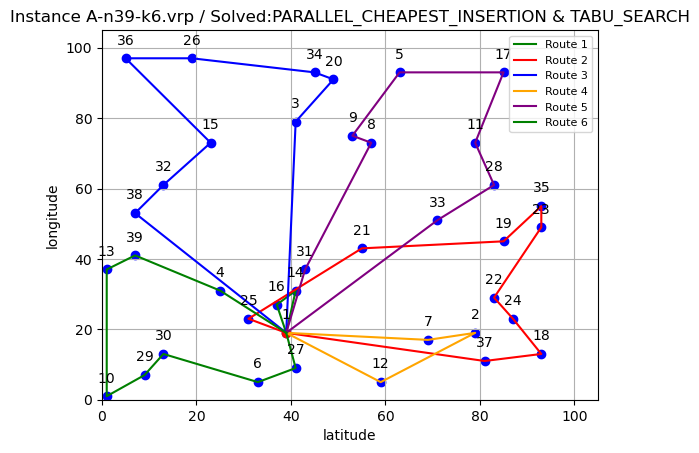

Local Search: GUIDED_LOCAL_SEARCH
Objective: 885
Route for vehicle 1:
 1 Load(0) ->  14 Load(72) ->  16 Load(88) ->  0 Load(88)
Distance of the route: 26m
Load of the route: 88

Route for vehicle 2:
 1 Load(0) ->  19 Load(22) ->  22 Load(33) ->  2 Load(51) ->  7 Load(70) ->  12 Load(88) ->  0 Load(88)
Distance of the route: 130m
Load of the route: 88

Route for vehicle 3:
 1 Load(0) ->  31 Load(9) ->  8 Load(15) ->  9 Load(21) ->  5 Load(45) ->  20 Load(68) ->  34 Load(77) ->  26 Load(93) ->  36 Load(100) ->  0 Load(100)
Distance of the route: 225m
Load of the route: 100

Route for vehicle 4:
 1 Load(0) ->  21 Load(7) ->  33 Load(18) ->  11 Load(30) ->  17 Load(53) ->  28 Load(60) ->  35 Load(63) ->  23 Load(74) ->  24 Load(75) ->  18 Load(79) ->  37 Load(94) ->  0 Load(94)
Distance of the route: 235m
Load of the route: 94

Route for vehicle 5:
 1 Load(0) ->  27 Load(15) ->  6 Load(18) ->  25 Load(40) ->  4 Load(62) ->  0 Load(62)
Distance of the route: 65m
Load of the route: 62

Route

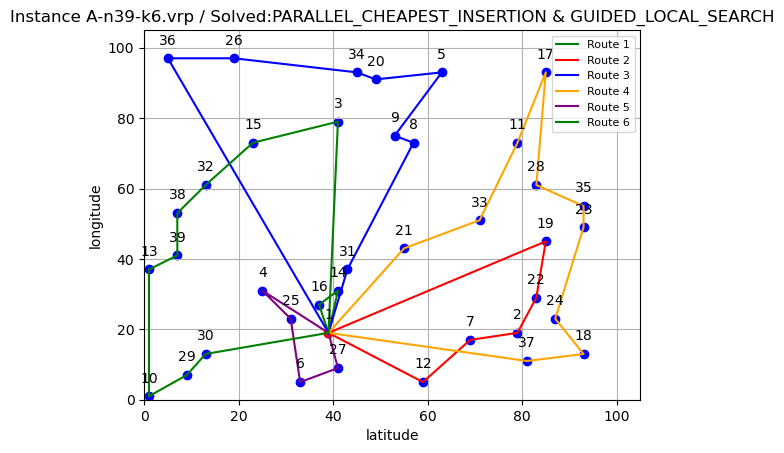

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 967
Route for vehicle 1:
 1 Load(0) ->  27 Load(15) ->  6 Load(18) ->  10 Load(24) ->  29 Load(29) ->  30 Load(51) ->  0 Load(51)
Distance of the route: 95m
Load of the route: 51

Route for vehicle 2:
 1 Load(0) ->  14 Load(72) ->  24 Load(73) ->  18 Load(77) ->  7 Load(96) ->  0 Load(96)
Distance of the route: 125m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  16 Load(16) ->  4 Load(38) ->  32 Load(48) ->  15 Load(55) ->  3 Load(71) ->  9 Load(77) ->  8 Load(83) ->  21 Load(90) ->  0 Load(90)
Distance of the route: 164m
Load of the route: 90

Route for vehicle 4:
 1 Load(0) ->  19 Load(22) ->  35 Load(25) ->  23 Load(36) ->  22 Load(47) ->  2 Load(65) ->  37 Load(80) ->  12 Load(98) ->  0 Load(98)
Distance of the route: 160m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  33 Load(11) ->  28 Load(18) ->  11 Load(30) ->  17 Load(53) ->  5 Load(77) ->  20 Load(100) ->  0 Load(100)
Distance of the route

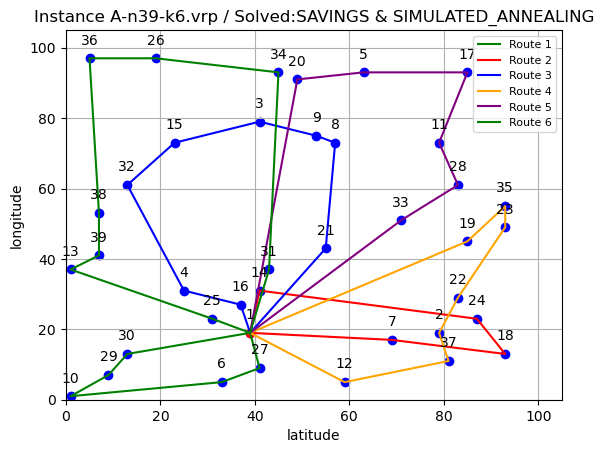

Local Search: TABU_SEARCH
Objective: 860
Route for vehicle 1:
 1 Load(0) ->  27 Load(15) ->  6 Load(18) ->  10 Load(24) ->  29 Load(29) ->  30 Load(51) ->  25 Load(73) ->  0 Load(73)
Distance of the route: 98m
Load of the route: 73

Route for vehicle 2:
 1 Load(0) ->  31 Load(9) ->  3 Load(25) ->  8 Load(31) ->  11 Load(43) ->  28 Load(50) ->  35 Load(53) ->  23 Load(64) ->  19 Load(86) ->  33 Load(97) ->  0 Load(97)
Distance of the route: 199m
Load of the route: 97

Route for vehicle 3:
 1 Load(0) ->  4 Load(22) ->  13 Load(38) ->  39 Load(40) ->  38 Load(50) ->  32 Load(60) ->  36 Load(67) ->  26 Load(83) ->  15 Load(90) ->  0 Load(90)
Distance of the route: 203m
Load of the route: 90

Route for vehicle 4:
 1 Load(0) ->  7 Load(19) ->  2 Load(37) ->  22 Load(48) ->  24 Load(49) ->  18 Load(53) ->  37 Load(68) ->  12 Load(86) ->  0 Load(86)
Distance of the route: 129m
Load of the route: 86

Route for vehicle 5:
 1 Load(0) ->  9 Load(6) ->  34 Load(15) ->  20 Load(38) ->  5 Load(62) ->

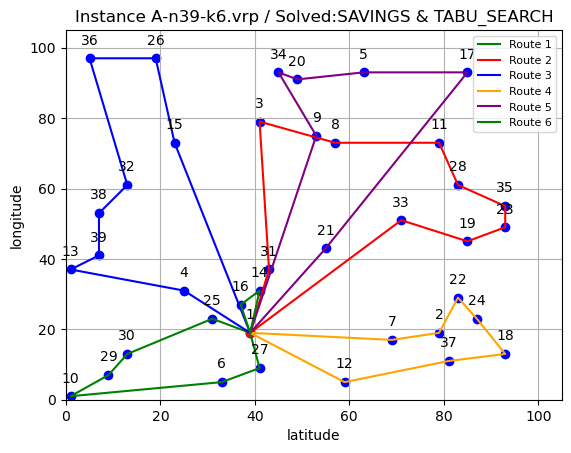

Local Search: GUIDED_LOCAL_SEARCH
Objective: 893
Route for vehicle 1:
 1 Load(0) ->  27 Load(15) ->  6 Load(18) ->  25 Load(40) ->  0 Load(40)
Distance of the route: 46m
Load of the route: 40

Route for vehicle 2:
 1 Load(0) ->  14 Load(72) ->  24 Load(73) ->  18 Load(77) ->  7 Load(96) ->  0 Load(96)
Distance of the route: 125m
Load of the route: 96

Route for vehicle 3:
 1 Load(0) ->  32 Load(10) ->  15 Load(17) ->  36 Load(24) ->  26 Load(40) ->  34 Load(49) ->  20 Load(72) ->  3 Load(88) ->  31 Load(97) ->  0 Load(97)
Distance of the route: 213m
Load of the route: 97

Route for vehicle 4:
 1 Load(0) ->  19 Load(22) ->  35 Load(25) ->  23 Load(36) ->  22 Load(47) ->  2 Load(65) ->  37 Load(80) ->  12 Load(98) ->  0 Load(98)
Distance of the route: 160m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  30 Load(22) ->  29 Load(27) ->  10 Load(33) ->  13 Load(49) ->  39 Load(51) ->  38 Load(61) ->  4 Load(83) ->  16 Load(99) ->  0 Load(99)
Distance of the route: 148m
Load of th

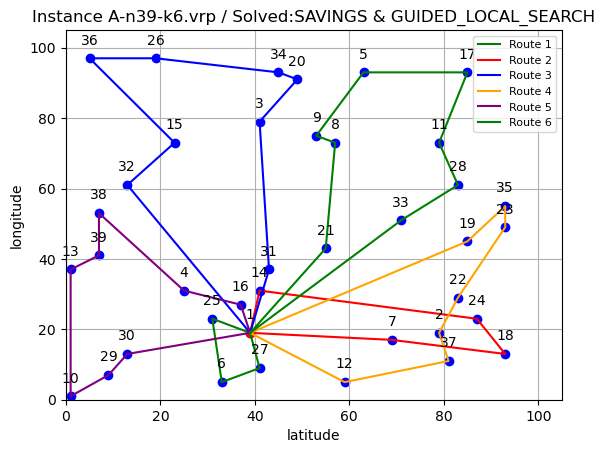

Soluzione ottima: 831
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 920
Gap: 10.709987966305656%
Tempo di esecuzione: 2.0000123977661133s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 859
Gap: 3.369434416365824%
Tempo di esecuzione: 2.0009994506835938s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 885
Gap: 6.4981949458483745%
Tempo di esecuzione: 2.000969886779785s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 967
Gap: 16.365824308062578%
Tempo di esecuzione: 2.00100040435791s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 860
Gap: 3.489771359807461%
Tempo di esecuzione: 2.000

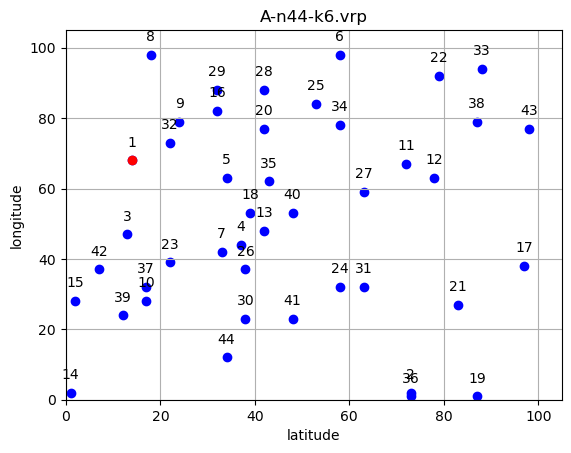

Soluzione ottima: 937
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 985
Route for vehicle 1:
 1 Load(0) ->  8 Load(9) ->  29 Load(23) ->  28 Load(47) ->  16 Load(51) ->  9 Load(65) ->  32 Load(88) ->  0 Load(88)
Distance of the route: 93m
Load of the route: 88

Route for vehicle 2:
 1 Load(0) ->  3 Load(24) ->  42 Load(28) ->  15 Load(46) ->  39 Load(50) ->  10 Load(53) ->  37 Load(71) ->  23 Load(80) ->  7 Load(98) ->  0 Load(98)
Distance of the route: 116m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  5 Load(19) ->  35 Load(33) ->  18 Load(47) ->  13 Load(55) ->  26 Load(79) ->  4 Load(88) ->  0 Load(88)
Distance of the route: 98m
Load of the route: 88

Route for vehicle 4:
 1 Load(0) ->  34 Load(13) ->  25 Load(16) ->  6 Load(25) ->  22 Load(27) ->  33 Load(36) ->  38 Load(60) ->  12 Load(68) ->  11 Load(82) ->  27 Load(90) ->  40 Load(98) ->  0 Load(98)
Distance of the route: 204m
Load of the route: 98

Route for vehicle 5:
 1 Load(

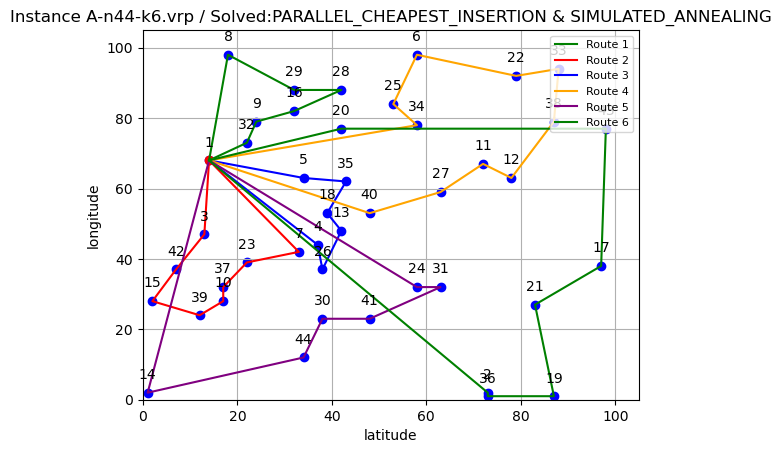

Local Search: TABU_SEARCH
Objective: 999
Route for vehicle 1:
 1 Load(0) ->  9 Load(14) ->  29 Load(28) ->  28 Load(52) ->  20 Load(70) ->  32 Load(93) ->  0 Load(93)
Distance of the route: 77m
Load of the route: 93

Route for vehicle 2:
 1 Load(0) ->  3 Load(24) ->  42 Load(28) ->  15 Load(46) ->  39 Load(50) ->  10 Load(53) ->  37 Load(71) ->  23 Load(80) ->  7 Load(98) ->  0 Load(98)
Distance of the route: 116m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  5 Load(19) ->  35 Load(33) ->  18 Load(47) ->  13 Load(55) ->  26 Load(79) ->  4 Load(88) ->  0 Load(88)
Distance of the route: 98m
Load of the route: 88

Route for vehicle 4:
 1 Load(0) ->  8 Load(9) ->  16 Load(13) ->  34 Load(26) ->  6 Load(35) ->  22 Load(37) ->  33 Load(46) ->  38 Load(70) ->  12 Load(78) ->  11 Load(92) ->  27 Load(100) ->  0 Load(100)
Distance of the route: 230m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  14 Load(13) ->  44 Load(31) ->  41 Load(44) ->  24 Load(62) ->  31 Load(86

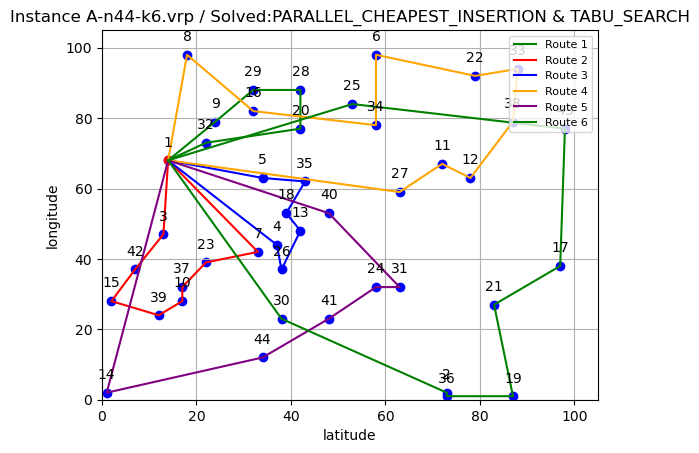

Local Search: GUIDED_LOCAL_SEARCH
Objective: 948
Route for vehicle 1:
 1 Load(0) ->  32 Load(23) ->  9 Load(37) ->  16 Load(41) ->  28 Load(65) ->  29 Load(79) ->  8 Load(88) ->  0 Load(88)
Distance of the route: 93m
Load of the route: 88

Route for vehicle 2:
 1 Load(0) ->  5 Load(19) ->  35 Load(33) ->  18 Load(47) ->  4 Load(56) ->  26 Load(80) ->  7 Load(98) ->  0 Load(98)
Distance of the route: 95m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  25 Load(3) ->  6 Load(12) ->  22 Load(14) ->  33 Load(23) ->  43 Load(37) ->  38 Load(61) ->  12 Load(69) ->  11 Load(83) ->  27 Load(91) ->  40 Load(99) ->  0 Load(99)
Distance of the route: 209m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  36 Load(14) ->  2 Load(22) ->  19 Load(30) ->  21 Load(43) ->  17 Load(67) ->  34 Load(80) ->  20 Load(98) ->  0 Load(98)
Distance of the route: 249m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  44 Load(18) ->  30 Load(31) ->  41 Load(44) ->  24 Load(62) ->  31 Lo

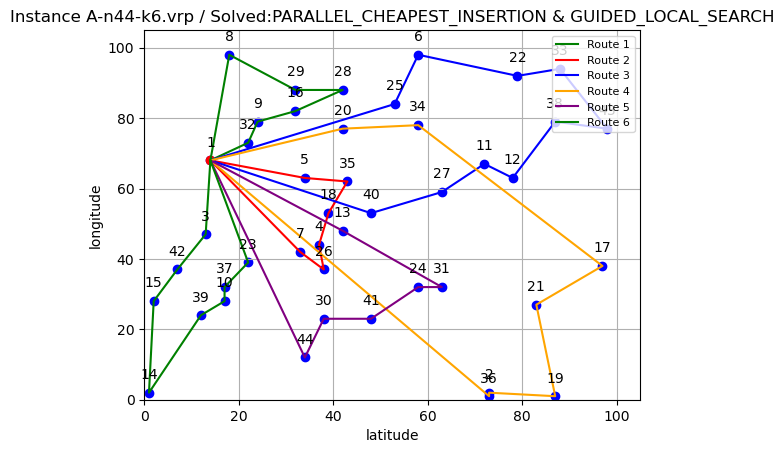

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 961
Route for vehicle 1:
 1 Load(0) ->  9 Load(14) ->  29 Load(28) ->  28 Load(52) ->  20 Load(70) ->  32 Load(93) ->  0 Load(93)
Distance of the route: 77m
Load of the route: 93

Route for vehicle 2:
 1 Load(0) ->  3 Load(24) ->  42 Load(28) ->  15 Load(46) ->  39 Load(50) ->  10 Load(53) ->  37 Load(71) ->  23 Load(80) ->  7 Load(98) ->  0 Load(98)
Distance of the route: 116m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  5 Load(19) ->  35 Load(33) ->  40 Load(41) ->  13 Load(49) ->  26 Load(73) ->  4 Load(82) ->  18 Load(96) ->  0 Load(96)
Distance of the route: 105m
Load of the route: 96

Route for vehicle 4:
 1 Load(0) ->  2 Load(8) ->  36 Load(22) ->  19 Load(30) ->  21 Load(43) ->  17 Load(67) ->  12 Load(75) ->  11 Load(89) ->  27 Load(97) ->  0 Load(97)
Distance of the route: 248m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  14 Load(13) ->  44 Load(31) ->  30 Load(44) ->  41 Load(57) ->  3

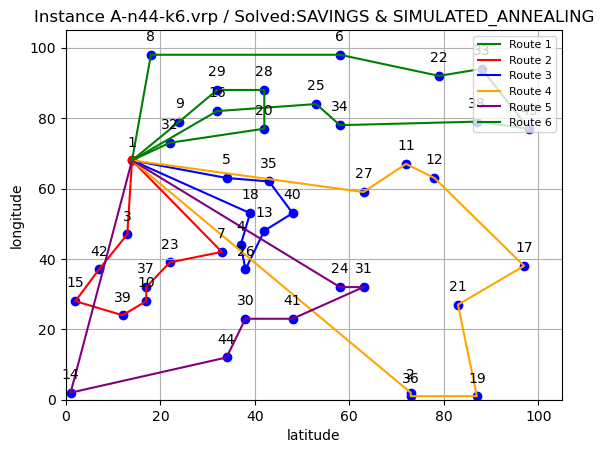

Local Search: TABU_SEARCH
Objective: 999
Route for vehicle 1:
 1 Load(0) ->  9 Load(14) ->  29 Load(28) ->  28 Load(52) ->  20 Load(70) ->  32 Load(93) ->  0 Load(93)
Distance of the route: 77m
Load of the route: 93

Route for vehicle 2:
 1 Load(0) ->  3 Load(24) ->  42 Load(28) ->  15 Load(46) ->  39 Load(50) ->  10 Load(53) ->  37 Load(71) ->  23 Load(80) ->  7 Load(98) ->  0 Load(98)
Distance of the route: 116m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  5 Load(19) ->  35 Load(33) ->  18 Load(47) ->  13 Load(55) ->  26 Load(79) ->  4 Load(88) ->  0 Load(88)
Distance of the route: 98m
Load of the route: 88

Route for vehicle 4:
 1 Load(0) ->  8 Load(9) ->  16 Load(13) ->  34 Load(26) ->  6 Load(35) ->  22 Load(37) ->  33 Load(46) ->  38 Load(70) ->  12 Load(78) ->  11 Load(92) ->  27 Load(100) ->  0 Load(100)
Distance of the route: 230m
Load of the route: 100

Route for vehicle 5:
 1 Load(0) ->  14 Load(13) ->  44 Load(31) ->  41 Load(44) ->  24 Load(62) ->  31 Load(86

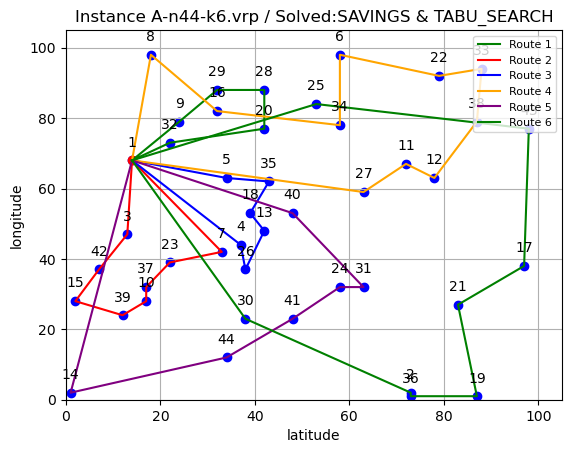

Local Search: GUIDED_LOCAL_SEARCH
Objective: 948
Route for vehicle 1:
 1 Load(0) ->  32 Load(23) ->  9 Load(37) ->  16 Load(41) ->  28 Load(65) ->  29 Load(79) ->  8 Load(88) ->  0 Load(88)
Distance of the route: 93m
Load of the route: 88

Route for vehicle 2:
 1 Load(0) ->  5 Load(19) ->  35 Load(33) ->  18 Load(47) ->  4 Load(56) ->  26 Load(80) ->  7 Load(98) ->  0 Load(98)
Distance of the route: 95m
Load of the route: 98

Route for vehicle 3:
 1 Load(0) ->  25 Load(3) ->  6 Load(12) ->  22 Load(14) ->  33 Load(23) ->  43 Load(37) ->  38 Load(61) ->  12 Load(69) ->  11 Load(83) ->  27 Load(91) ->  40 Load(99) ->  0 Load(99)
Distance of the route: 209m
Load of the route: 99

Route for vehicle 4:
 1 Load(0) ->  2 Load(8) ->  36 Load(22) ->  19 Load(30) ->  21 Load(43) ->  17 Load(67) ->  34 Load(80) ->  20 Load(98) ->  0 Load(98)
Distance of the route: 249m
Load of the route: 98

Route for vehicle 5:
 1 Load(0) ->  44 Load(18) ->  30 Load(31) ->  41 Load(44) ->  24 Load(62) ->  31 Loa

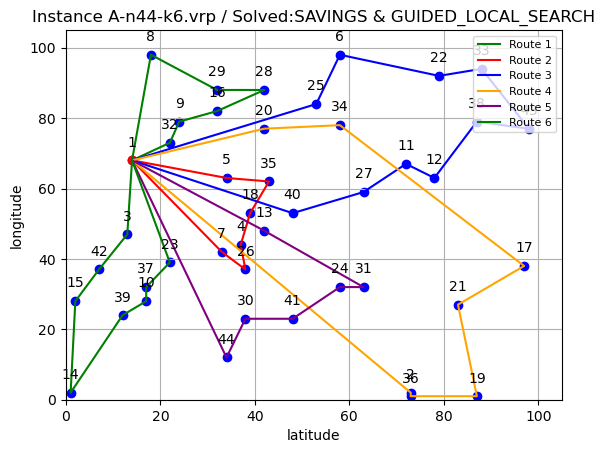

Soluzione ottima: 937
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 985
Gap: 5.122732123799359%
Tempo di esecuzione: 1.9999947547912598s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 999
Gap: 6.616862326574173%
Tempo di esecuzione: 2.0009658336639404s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 948
Gap: 1.1739594450373532%
Tempo di esecuzione: 2.0010008811950684s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 961
Gap: 2.5613660618996796%
Tempo di esecuzione: 1.9989697933197021s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 999
Gap: 6.616862326574173%
Tempo di esecuzione: 2.0

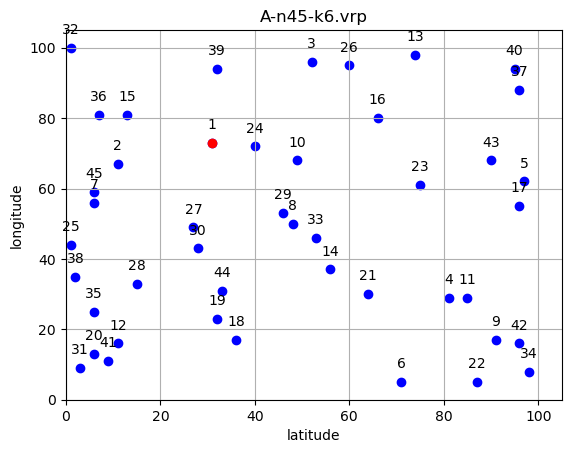

Soluzione ottima: 944
SOLUTION: PARALLEL_CHEAPEST_INSERTION
Local Search: SIMULATED_ANNEALING
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of t

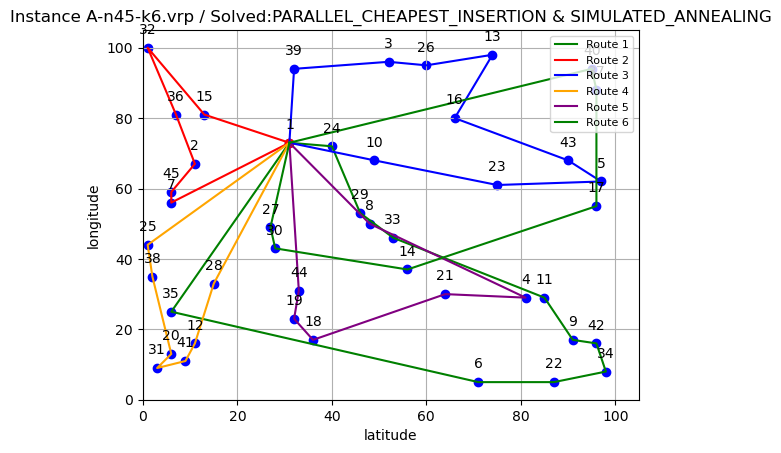

Local Search: TABU_SEARCH
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  44 Load(18) ->  19

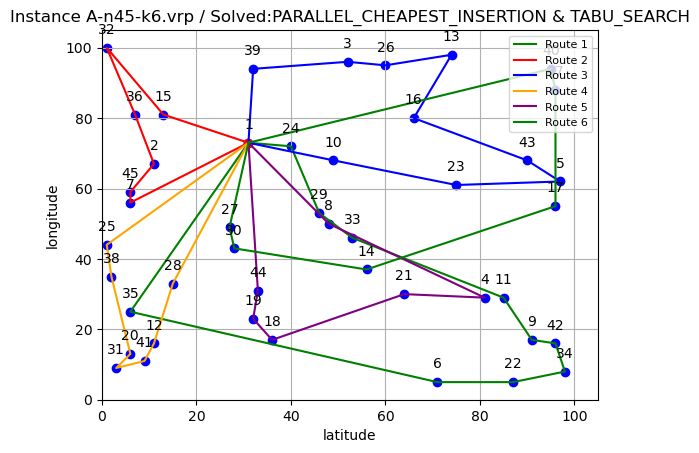

Local Search: GUIDED_LOCAL_SEARCH
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  44 Load(18

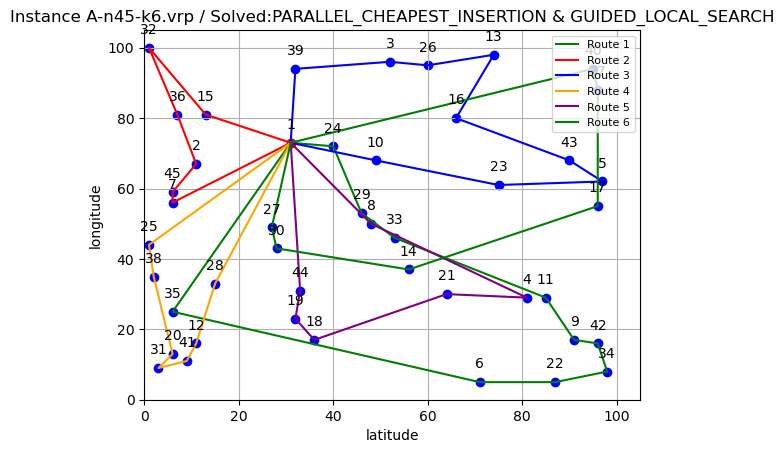

SOLUTION: SAVINGS
Local Search: SIMULATED_ANNEALING
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of the route: 97

Route for vehicle 5:
 1 Load

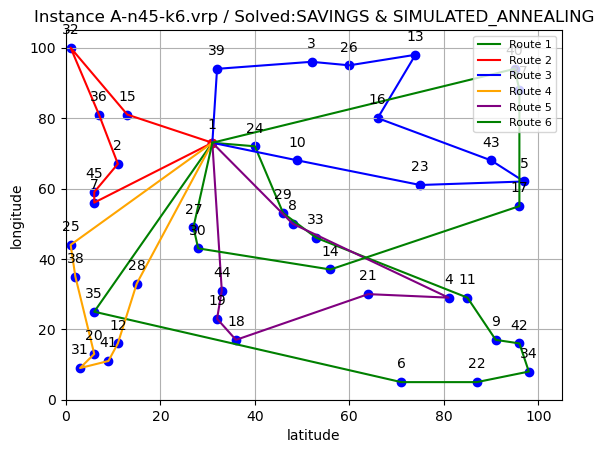

Local Search: TABU_SEARCH
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  44 Load(18) ->  19

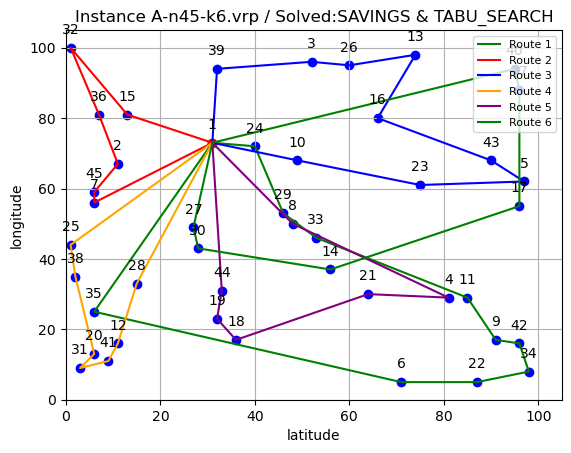

Local Search: GUIDED_LOCAL_SEARCH
Objective: 1087
Route for vehicle 1:
 1 Load(0) ->  35 Load(11) ->  6 Load(17) ->  22 Load(27) ->  34 Load(38) ->  42 Load(43) ->  9 Load(57) ->  11 Load(65) ->  33 Load(73) ->  29 Load(94) ->  24 Load(100) ->  0 Load(100)
Distance of the route: 250m
Load of the route: 100

Route for vehicle 2:
 1 Load(0) ->  15 Load(14) ->  32 Load(30) ->  36 Load(52) ->  2 Load(71) ->  45 Load(83) ->  7 Load(100) ->  0 Load(100)
Distance of the route: 119m
Load of the route: 100

Route for vehicle 3:
 1 Load(0) ->  39 Load(17) ->  3 Load(19) ->  26 Load(29) ->  13 Load(36) ->  16 Load(53) ->  43 Load(56) ->  5 Load(76) ->  23 Load(96) ->  10 Load(98) ->  0 Load(98)
Distance of the route: 187m
Load of the route: 98

Route for vehicle 4:
 1 Load(0) ->  25 Load(21) ->  38 Load(43) ->  20 Load(45) ->  31 Load(56) ->  41 Load(79) ->  12 Load(84) ->  28 Load(97) ->  0 Load(97)
Distance of the route: 149m
Load of the route: 97

Route for vehicle 5:
 1 Load(0) ->  44 Load(18

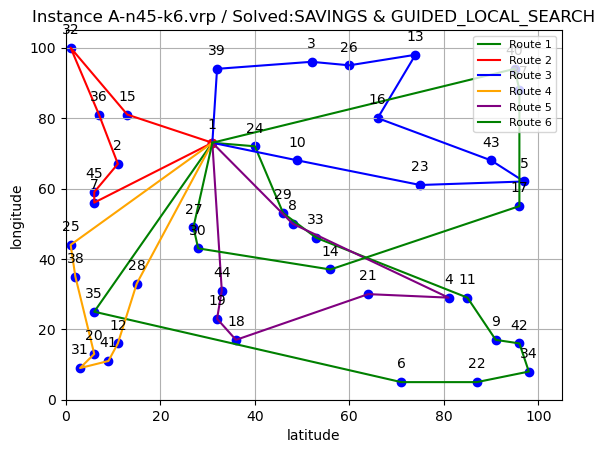

Soluzione ottima: 944
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 1087
Gap: 15.148305084745765%
Tempo di esecuzione: 1.9999961853027344s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 1087
Gap: 15.148305084745765%
Tempo di esecuzione: 2.0010342597961426s
----------------------------------------
Algoritmo utilizzato: PARALLEL_CHEAPEST_INSERTION
Opzione di ricerca locale: GUIDED_LOCAL_SEARCH
Soluzione: 1087
Gap: 15.148305084745765%
Tempo di esecuzione: 2.001028060913086s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: SIMULATED_ANNEALING
Soluzione: 1087
Gap: 15.148305084745765%
Tempo di esecuzione: 1.9999918937683105s
----------------------------------------
Algoritmo utilizzato: SAVINGS
Opzione di ricerca locale: TABU_SEARCH
Soluzione: 1087
Gap: 15.148305084745765%
Tempo di esecuzio

In [14]:
avg_gap= [] #Conterrà le medie dei gap calcolati per ogni algoritmo
avg_tempi = [] #Conterrà le medie dei tempi di calcolo
dim_p = [] #Conterrà le diverse dimensioni delle istanze risolte

#tempi_tutti = []

#Variabile per impostare il numero di file di istanze da leggere
#Max file = len(nomi_file)
num_file = 12
for i in range(num_file):
    print("Solving INSTANCE:",nomi_file[i])
    
    # RESET delle variabili
    capacity = None #Capacita dei veicoli
    node_coord_section = [] #Coordinate dei nodi
    demand_section = [] #Richieste dei nodi
    depot_section = [] #Sezione del deposito
    num_vehicl = 0 #Numero di veicoli
    
    #Leggo il file
    read_file(nomi_file[i])
    
    #Plotto l'istanza del problema
    instance_plot(nomi_file[i])
    
    #Salvo la dimensione del problema
    dim_p.append(num_vehicl)
    
    #Calcola la matrice delle distanze sulla base delle coordinate
    distance_matrix = create_distance_matrix(node_coord_section)

    total_distance= 0

    #Istanzio il problema nel dizionario
    data = create_data_model(distance_matrix, demand_section, capacity, num_vehicl)
    
    sol = []
    
    #debug
    #     for row in data['distance_matrix']:
    #         print(row)
    #     print("Demands:")
    #     print(data['demands'])
    #     print("Vehicle Capacities:")
    #     print(data['vehicle_capacities'])
    #     print("Number of Vehicles:")
    #     print(data['num_vehicles'])
    #     print("Depot:")
    #     print(data['depot'])

    #Creo gestore dell'indice
    manager = pywrapcp.RoutingIndexManager(len(data['distance_matrix']),
                                   data['num_vehicles'], data['depot'])

    #Crea modello di routing
    routing = pywrapcp.RoutingModel(manager)
    
    #Le precedenti
    #Sono funzioni necessarie per utilizzare le funzioni della libreria OR-tools 
    
    #Indice per richiamare la funzione di calcolo distanza
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    #Definisce i costi sugli archi 
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    #Indice per richiamare la funzione di domanda per i nodi
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    
    #Aggiunge le dimensioni al problema, capacita massima, slack,domanda nodi
    routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data['vehicle_capacities'],  # vehicle maximum capacities
    True,  # start cumul to zero
    'Capacity')
    
    #Euristiche:
    FS = ["PARALLEL_CHEAPEST_INSERTION","SAVINGS"]
    #Metauiristiche
    LSM = ["SIMULATED_ANNEALING","TABU_SEARCH","GUIDED_LOCAL_SEARCH"]

    read_sol(nomi_sol[i])
    print("Soluzione ottima:",sol_opt)
    gap= []
    sol= []
    #Itero tra gli algoritmi di prima soluzione e applico una metauristica diversa per ognuno
    for x in range(len(FS)):
        print("SOLUTION:", FS[x])
        for y in range(len(LSM)):
            print("Local Search:", LSM[y])
            solve_routing_problem(nomi_file[i],FS[x],LSM[y])
            #tempi_tutti.append(sol[][1])
            #print("Prova:",tempi_tutti)
            
            
    #Calcolo il gap dall'ottimo
    calc_gap(sol_opt)
    print(gap)
    #CALCOLO il gap medio per ogni algoritmo e il tempo medio di esecuzione
    somma = 0
    somma_tempi = 0
    # Ciclo for da 0 a 2
    for z in range(3):
        somma += gap[z]
        somma_tempi += sol[z][1]
    avg=somma/3
    avg_t= somma_tempi / 3
    avg_gap.append(avg)
    avg_tempi.append(avg_t)
    somma=0
    somma_tempi = 0
    for z in range(3,6):
        somma += gap[z]
        somma_tempi += sol[z][1]
    avg=somma/3
    avg_t= somma_tempi / 3
    avg_gap.append(avg)
    avg_tempi.append(avg_t)
   # print(avg_gap)
    #print(avg_tempi)

    
    # #debug   
    # #print (sol)
    
    print("FINE ITER N:",i+1)

print("Numero di veicoli:",dim_p)
    

In [15]:
algorithms = ["PARALLEL_CHEAPEST_INSERTION", "SAVINGS"] * num_file
#print(algorithms)

24


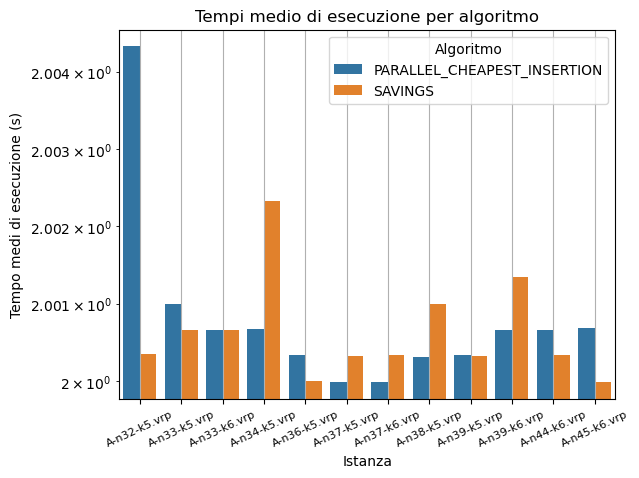

In [21]:
nuomi= []
for i in range(num_file):
    for j in range(2):
        nuomi.append(nomi_file[i])

        #debug        
#print(nuomi)
# print(len(algorithms))
# print(len(avg_tempi))
print(len(nuomi))



# # Creazione del DataFrame
data = pd.DataFrame({'Algoritmo': algorithms, 'Tempo medio di esecuzione': avg_tempi, 'Istanza': nuomi})

# Creazione del barplot con Seaborn
sns.barplot(x='Istanza', y='Tempo medio di esecuzione', data=data, hue='Algoritmo')
plt.title('Tempi medio di esecuzione per algoritmo')
plt.xlabel('Istanza')
plt.ylabel('Tempo medi di esecuzione (s)')
plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=25, fontsize=8)

# Mostra il grafico
plt.show()

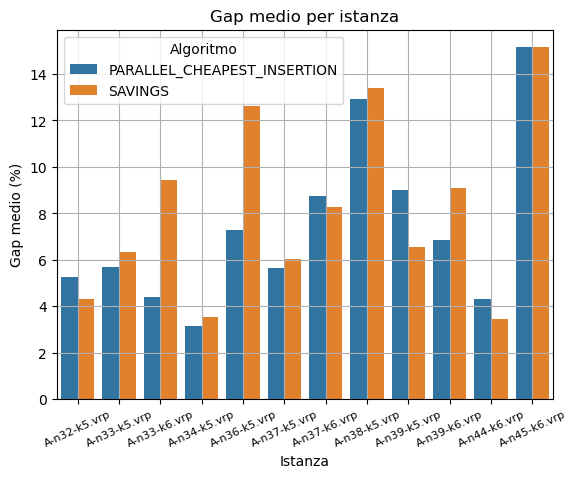

In [17]:
data = pd.DataFrame({'Algoritmo': algorithms, 'Gap Medio': avg_gap, 'Istanza': nuomi})

# Creazione del barplot con Seaborn
sns.barplot(x='Istanza', y='Gap Medio', data=data, hue='Algoritmo')
plt.title('Gap medio per istanza')
plt.xlabel('Istanza')
plt.ylabel('Gap medio (%)')
#plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=25, fontsize=8)

# Mostra il grafico
plt.show()

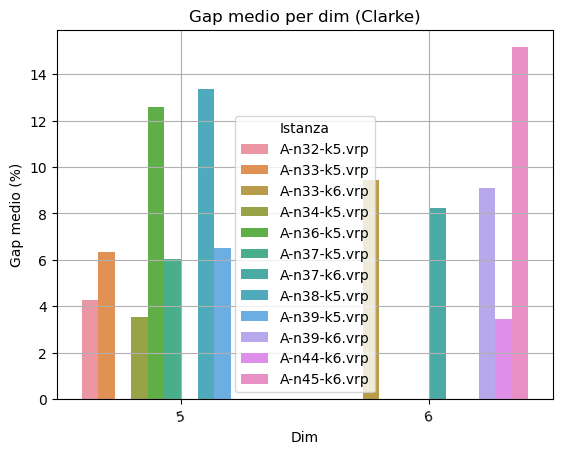

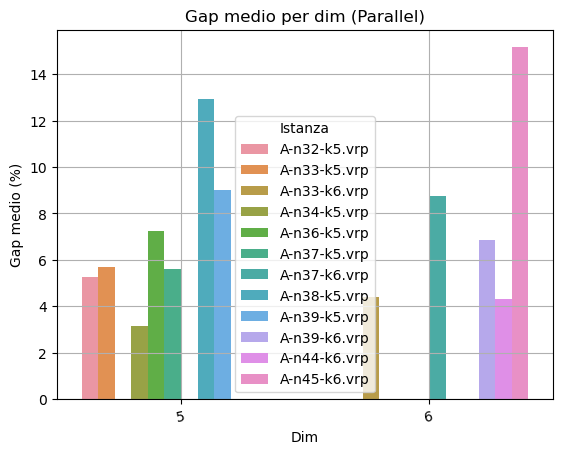

In [18]:
# dimi= []
# for i in range(num_file):
#     for j in range(2):
#         dimi.append(dim_p[i])
gapS= []
gapP= []
for i in range(num_file * 2):
    #Se sta in posizione pari è l'avg dell'algoritmo parallel
    if i % 2 == 0:
        gapP.append(avg_gap[i])
    #Se sta in posizione dispari è l'avg dell'algoritmo di clarke
    else:
        gapS.append(avg_gap[i])
nomini= []
for i in range(num_file):
    nomini.append(nomi_file[i])
    
# # print(avg_gap)
# # print(len(dimi))
# # print(len(avg_gap))
# # print(len(nuomi))
# print(gapS)
# print(dim_p)
# print(nomini)

data = pd.DataFrame({'Dim': dim_p, 'Gap Medio Clarke': gapS, 'Istanza': nomini,'Gap Medio Parallel': gapP,})

# Creazione del barplot con Seaborn
sns.barplot(x='Dim', y='Gap Medio Clarke', data=data, hue='Istanza')
plt.title('Gap medio per dim (Clarke)')
plt.xlabel('Dim')
plt.ylabel('Gap medio (%)')
#plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=10, fontsize=10)

# Mostra il grafico
plt.show()


# Creazione del barplot con Seaborn
sns.barplot(x='Dim', y='Gap Medio Parallel', data=data, hue='Istanza')
plt.title('Gap medio per dim (Parallel)')
plt.xlabel('Dim')
plt.ylabel('Gap medio (%)')
#plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=10, fontsize=10)

# Mostra il grafico
plt.show()


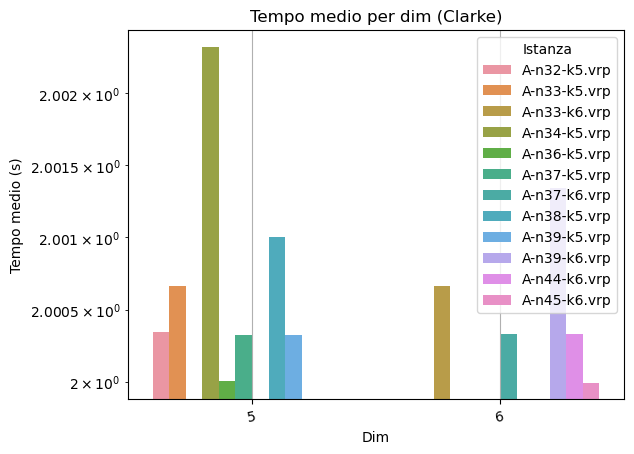

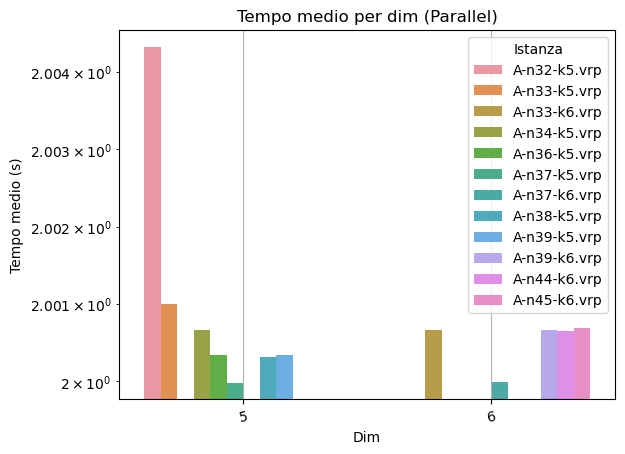

In [23]:
avgS= []
avgP= []
for i in range(num_file * 2):
    #Se sta in posizione pari è l'avg dell'algoritmo parallel
    if i % 2 == 0:
        avgP.append(avg_tempi[i])
    #Se sta in posizione dispari è l'avg dell'algoritmo di clarke
    else:
        avgS.append(avg_tempi[i])

# print(len(avgS))
# print(len(dim_p))
# print(len(nomini))

data = pd.DataFrame({'Dim': dim_p, 'Tempo Medio Clarke': avgS, 'Istanza': nomini,'Tempo Medio Parallel': avgP,})

# Creazione del barplot con Seaborn
sns.barplot(x='Dim', y='Tempo Medio Clarke', data=data, hue='Istanza')
plt.title('Tempo medio per dim (Clarke)')
plt.xlabel('Dim')
plt.ylabel('Tempo medio (s)')
plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=10, fontsize=10)

# Mostra il grafico
plt.show()


# Creazione del barplot con Seaborn
sns.barplot(x='Dim', y='Tempo Medio Parallel', data=data, hue='Istanza')
plt.title('Tempo medio per dim (Parallel)')
plt.xlabel('Dim')
plt.ylabel('Tempo medio (s)')
plt.yscale('log')
plt.grid()
# Rimpicciolire i nomi degli algoritmi
plt.xticks(rotation=10, fontsize=10)

# Mostra il grafico
plt.show()
